In [1]:
import pandas as pd
from tqdm import tqdm
import os
import openai
import numpy as np
import pickle as pk
import seaborn as sns
import matplotlib.pyplot as plt
import json
keys = json.load(open("keys.json"))
os.environ["OPENAI_API_KEY"]=keys["OPENAI_API_KEY"]
openai.api_key = os.environ.get("OPENAI_API_KEY")
import together
os.environ["TOGETHER_API_KEY"]=keys["TOGETHER_API_KEY"]
together.api_key = os.environ.get("TOGETHER_API_KEY")
# pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('future.no_silent_downcasting', True)
from scipy.stats import chisquare

to do:
1. Define a statistical way to reject features
2. Why AUT is not optimal
3. Define a measure of clumping - compare in default vs unrelated vs related 
4. Think of models, test some models

In [2]:
vf_to_remove = ["dog cat monkey rat mouse hamster crocodile lion zebra giraffe elephant beaver hare rabbit parrot heron duck", "cow bull chicken dog cat shepherd", "cat dog lion tiger parrot monkey human food cows milk eggs hamster", "monkey dog cat guinea pig rabbit horsecow duck goat chicken elephant giraffe meerkat", " store", "tit", "python", "mammal", "le", "okay", "sea animals", "land animals", "mammals", "diversity", "birds", "unicorn", "dragon", "bird", "man", "pets", "winnie poo"]

In [3]:
def together_call(prompt: str) -> str:
    """
    Calls TOGETHER API with input prompt.
    """
    output = together.Complete.create(
        prompt=prompt,
        model="meta-llama/Llama-3-70b-chat-hf",
        temperature=0,
        max_tokens=512,
        stop=[")", ")```"],
    )
    text_output = output["choices"][0]["text"].replace("assistant", "").replace("\n", "").replace("```", "")
    match = re.split(r"\)+", text_output, maxsplit=1)
    if match:
        return match[0]
    return text_output

def summarise_cluster(cluster_texts):
    text = ",".join(cluster_texts)
    # prompt = f"Summarise the sentences with a single theme phrase. Also output the mean similarity of the sentences on a scale of 1-5. Output format: (theme comma similarity) in round brackets (). Do not output any other words or text.\nSentences: [{text}]."
    prompt = f"Summarise the sentences with a single theme phrase. Output format: (theme). Do not output any other words or text.\nSentences: [{text}]."
    
    try:
        answer = together_call(prompt)
    except Exception as e:
        print("Error:", e)
        answer = "NA"
    # return str(len(cluster_texts)) + ", " + answer.replace("(", "")
    return answer.replace("(", "")

In [4]:
def gpt_call(prompt: str, model: str, temp: float) -> str:
    '''
    Calls OPENAI API with input and system prompt.
    '''
    response = openai.OpenAI().chat.completions.create(
        model = model,
        temperature = temp,
        max_tokens = 512,
        stop = ["]", "].", "]\n", "],"],
        messages=[
            {"role": "user", "content": prompt}
        ]
    )

    return response.choices[0].message.content

def get_features(texts, task):
    for text in tqdm(texts):
        if text in text_to_features[task]:
            continue
        
        if task == "autbrick":
            prompt = f'''I have responses for alternate uses of a brick. 
        For the response {text}, give me and 0 (no) / 1 (yes) label for each of the following 130 features as a binary comma-separated list in square braces '[]':

        1. Can hold weight
        2. Provides elevation
        3. Used for construction
        4. Serves as a tool
        5. Used for organization
        6. Provides insulation
        7. Used in outdoor environments
        8. Provides seating
        9. Decorative use
        10. Involves stacking
        11. Aids in cooking
        12. Works as an anchor
        13. For crafting/art
        14. Offers protection/security
        15. Used for grinding/crushing
        16. Functions as a toy/game
        17. Involves digging
        18. For holding objects
        19. Provides heat retention
        20. Adds balance/stability
        21. Garden/landscaping use
        22. Supports furniture
        23. Used as a weapon
        24. Holds or displays items
        25. Sports-related
        26. Simulates real-world items (like food)
        27. Serves as a fence/barrier
        28. DIY home improvement
        29. Functions as a paperweight
        30. Used as a path or pavement
        31. Holds plants
        32. Provides traction
        33. Used as storage
        34. Supports cleaning
        35. Acts as a boundary
        36. Can be customized/painted
        37. Emulates animal toys/enrichment
        38. Cooking utensil function
        39. Makes sound (percussion)
        40. Used in fitness/weight training
        41. Marks boundaries or areas
        42. Provides seating/elevation for small tasks
        43. Indoor use
        44. Outdoor use
        45. Heat resistance
        46. Functions in protection
        47. Provides structural support
        48. Absorbs or transfers heat
        49. Used as art canvas
        50. Child-friendly toy
        51. Used as a foundation
        52. Can be glued or stuck together
        53. Holds liquids
        54. Used in teaching/education
        55. Historical/cultural significance
        56. Provides warmth
        57. Decorative lighting/illumination
        58. Fire resistance
        59. Functions as a miniature model
        60. Used in construction training
        61. Used for meditation or spiritual purposes
        62. Provides ground preparation for surfaces
        63. Temporary usage only
        64. Lightweight action
        65. Can be hollowed out or carved
        66. Can be heated or frozen
        67. Involves fine detail work (carving, engraving)
        68. Used for water retention/conservation
        69. For animal shelter/enrichment
        70. Functions as a weight/resistance tool
        71. Symbolic purpose (e.g., memorial)
        72. Mold for other materials
        73. Holds or organizes paper/documents
        74. Marks location or property
        75. Provides traction in icy/slippery conditions
        76. Supports outdoor play or games
        77. Used in gardening/planting
        78. Food-related preparation use
        79. Fits together modularly
        80. Urban infrastructure element
        81. Used as a temporary stand
        82. Helps prevent movement
        83. Assists in cutting/slicing
        84. Can be a solid color or painted
        85. Used for creative DIY projects
        86. Repurposed from another use
        87. Related to home security
        88. Works as a sound buffer or amplifier
        89. Holds fragile objects in place
        90. Non-functional decorative purpose
        91. Has industrial uses (e.g., for machines)
        92. Mimics natural stones/rocks
        93. Provides resistance to wear or pressure
        94. Maintains or marks temperature
        95. Acts as a table stabilizer
        96. Helps keep items organized
        97. Compatible with glue or adhesives
        98. Can withstand pressure or impact
        99. Affects airflow or ventilation
        100. Can be set up or removed easily
        101. Heavy or dense
        102. Lightweight
        103. Rough surface
        104. Smooth surface
        105. Porous material
        106. Water-resistant
        107. Fireproof
        108. Heat-absorbing
        109. Conductive (e.g., heat or electricity)
        110. Brittle or prone to shattering
        111. Durable/hard-wearing
        112. Flexible (can be shaped/molded)
        113. Sharp edges
        114. Rounded edges
        115. High friction surface (non-slip)
        116. Low friction surface (slippery)
        117. Resistant to erosion or weathering
        118. Reflective or shiny
        119. Opaque (does not allow light through)
        120. Translucent (allows some light through)
        121. Breakable into smaller pieces
        122. Contains color naturally (e.g., reddish-brown for clay bricks)
        123. Susceptible to cracking under pressure
        124. Absorbs moisture
        125. Non-magnetic
        126. Resists compression
        127. Can be compacted or layered
        128. Reactive to chemicals (e.g., lime in cement reacts with water)
        129. High thermal mass (retains temperature for long periods)
        130. Tends to expand or contract with temperature changes'''
        elif task == "autpaperclip":
            prompt = f'''I have responses for alternate uses of a paperclip. 
            For the response {text}, give me and 0 (no) / 1 (yes) label for each of the following 130 features as a binary comma-separated list in square braces '[]':

            1. Acts as a Holder
            2. Used in Crafting
            3. For Decoration
            4. Organizational Tool
            5. For Jewelry Making
            6. Emergency Tool
            7. Hair Accessories
            8. Cleaning Tool
            9. Makeshift Key
            10. Electrical Conductor
            11. Can Be Bent
            12. Temporary Repair
            13. Fashion Accessory
            14. For Paper Binding
            15. Medical Use
            16. Unclogging Tool
            17. Tool for Marking
            18. Household Tool
            19. Cooking Aid
            20. Experimental Tool
            21. Writing Aid
            22. Educational Use
            23. Hanging or Mounting
            24. Game or Toy
            25. Practical Art
            26. Clothes Fastening
            27. Home Decor
            28. Stress Relief
            29. Plant Support
            30. Signaling Device
            31. Key Management
            32. Tool for Threading
            33. Used in Repair
            34. Flexible Material
            35. Portable Size
            36. Utilizes Magnetic Properties
            37. Camping Gear
            38. Simple Machine Element
            39. Can Be Sharpened
            40. Battery Holder
            41. Craft Embellishment
            42. Medical Instrument
            43. Fixing Tools
            44. Engages in Symbolism
            45. Instrument for Piercing
            46. Microwave Safe
            47. For Binding Documents
            48. For Labeling
            49. Capable of Locking
            50. Can Be Combined with Other Tools
            51. Functions as a Marker
            52. Utilized in Outdoor Activities
            53. Can Conduct Heat
            54. Organizing Tool for Cables
            55. Stringing Capability
            56. Can Open Small Objects
            57. Home Repair Utility
            58. Reusability
            59. Holds Shape Under Pressure
            60. Packaging Utility
            61. Decoration for Holidays
            62. Aids in Food Preservation
            63. Mechanical Use
            64. Unsticking Small Items
            65. Suitable for Detangling
            66. Can Hold a Magnetic Charge
            67. Scales Down for Miniature Models
            68. Works as a Fastener
            69. Acts as a Divider
            70. Fine Motor Tool
            71. Works for Beadwork
            72. Aids in Safety
            73. Serves as a Scraper
            74. Appealing to Kids
            75. Connects Objects
            76. Can Be Painted
            77. Useful in Electronics
            78. Suitable for Weight Bearing
            79. Utilized in Sculpture
            80. Nonpermanent Tool
            81. Helpful for Packing
            82. Pin-like Functionality
            83. Can Be Decorated
            84. Adaptable Shape
            85. Clothesline Clip
            86. Aesthetic Enhancer
            87. Includes a Loop
            88. Can Function as a Wedge
            89. Helps in Counting
            90. Secure Closure
            91. Eyelet Creation
            92. Helps with Insertion
            93. Functions as a Lever
            94. For Bag Organization
            95. Suitable for Knotting
            96. Used for Pinning
            97. Simple Adhesive Substitute
            98. Building Material
            99. Good for Sorting
            100. Acts as an Engraving Tool
            101. Corrosion-Resistant
            102. Flexible Ends
            103. Non-toxic Coating
            104. High Reflectivity
            105. Low Reflectivity
            106. Colorful
            107. Transparent
            108. Opaque
            109. High Friction
            110. Non-flammable
            111. Scratch-Resistant
            112. Break-Resistant
            113. UV-Resistant
            114. Hypoallergenic
            115. Non-reactive
            116. Eco-Friendly Material
            117. Compact Shape
            118. Elasticity
            119. Sharp Ends
            120. Rounded Points
            121. Springy
            122. Lightweight
            123. Rust-Prone
            124. Sturdy Core
            125. Polished Finish
            126. Textile Friendly
            127. Dual-Layer Coating
            128. Minimal Deformation
            129. Smooth surface
            130. Ductile'''
        elif task == "vf":
            prompt = f'''For the animal {text}, give me and 0 (no) / 1 (yes) label for each of the following 130 features as a binary comma-separated list in square braces '[]':

            1. Is mammal
            2. Is bird
            3. Is insect
            4. Is reptile
            5. Is amphibian
            6. Is fish
            7. Is carnivore
            8. Is herbivore
            9. Is omnivore
            10. Has fur
            11. Has feathers
            12. Has scales
            13. Has exoskeleton
            14. Has beak
            15. Has claws
            16. Has whiskers
            17. Has horns
            18. Has antlers
            19. Has tusks
            20. Has wings
            21. Has tail
            22. Can fly
            23. Can swim
            24. Can climb
            25. Can dig
            26. Can jump
            27. Is nocturnal
            28. Is diurnal
            29. Has more than four limbs
            30. Lives in water
            31. Lives in trees
            32. Lives underground
            33. Lives on land
            34. Lays eggs
            35. Gives birth
            36. Has scales
            37. Has a long neck
            38. Is venomous
            39. Is domesticated
            40. Lives in groups
            41. Is solitary
            42. Builds nests
            43. Is migratory
            44. Has social hierarchy
            45. Uses tools
            46. Shows intelligence
            47. Communicates vocally
            48. Has camouflage
            49. Has stripes
            50. Has spots
            51. Can change color
            52. Is endangered
            53. Is commonly kept as a pet
            54. Is used in farming
            55. Is hunted by humans
            56. Is used for food by humans
            57. Is found in zoos
            58. Is capable of mimicry
            59. Has echolocation
            60. Is warm-blooded
            61. Is cold-blooded
            62. Has a long lifespan
            63. Is capable of regrowth
            64. Has specialized hunting techniques
            65. Is known for speed
            66. Is known for strength
            67. Has a specialized diet
            68. Is migratory
            69. Can hibernate
            70. Has a backbone
            71. Is marsupial
            72. Is placental
            73. Is monotreme
            74. Is flightless
            75. Has webbed feet
            76. Is known for intelligence
            77. Is a scavenger
            78. Is territorial
            79. Is native to Africa
            80. Is native to Asia
            81. Is native to North America
            82. Is native to South America
            83. Is native to Australia
            84. Is native to Europe
            85. Is found in deserts
            86. Is found in forests
            87. Is found in oceans
            88. Is found in grasslands
            89. Is found in mountains
            90. Has a mane
            91. Has a crest
            92. Has gills
            93. Is bioluminescent
            94. Is used in scientific research
            95. Is a predator
            96. Is prey for larger animals
            97. Is capable of parental care
            98. Lives in a burrow
            99. Is a pollinator
            100. Can tolerate extreme temperatures
            101. Exhibits seasonal color changes
            102. Migrates seasonally
            103. Is active during dawn or dusk (crepuscular)
            104. Produces pheromones for communication
            105. Lives symbiotically with other species
            106. Is a parasite
            107. Is a host for parasites
            108. Is bi-parental (both parents care for offspring)
            109. Displays mating rituals
            110. Has specialized courtship behavior
            111. Exhibits territorial marking
            112. Is associated with mythology or folklore
            113. Is endangered
            114. Exhibits altruistic behavior
            115. Is a keystone species in its ecosystem
            116. Uses burrows or dens for shelter
            117. Can regenerate body parts
            118. Is raised in captivity or farms
            119. Has unique reproductive strategies (e.g., asexual reproduction)
            120. Hibernates during winter
            121. Has a role in biological pest control
            122. Has distinct seasonal breeding cycles
            123. Forms a symbiotic relationship with plants (e.g., pollination)
            124. Uses specific vocalizations to communicate
            125. Is a flagship species (conservation symbol)
            126. Can be trained or tamed by humans
            127. Displays warning coloration
            128. Has flippers
            129. Has compound eyes
            130. Has a segmented body'''
        
        cnt = 0
        while True:
            try:
                response = gpt_call(prompt, "gpt-4o", 0)
            except Exception as e:
                print("Error:", e)
                response = 'NA'
        
            response = response[response.find("[") + 1:]
            print(text, response.count(","))
            print(response)
            cnt += 1
            if response.count(",") == 129 or cnt == 3:
                break

        text_to_features[task][text] = response

In [5]:
data = pd.read_csv("../csvs/data_humans_allresponses.csv")

data_autbrick = data[data["task"] == 2].reset_index(drop=True)
data_autpaperclip = data[data["task"] == 3].reset_index(drop=True)
data_vf = data[data["task"] == 1].reset_index(drop=True)

texts_autbrick = data_autbrick["response"].unique().tolist()

texts_autpaperclip = data_autpaperclip["response"].unique().tolist()
texts_vf = data_vf["response"].unique().tolist()

tasks = ["autbrick", "autpaperclip", "vf"]

In [6]:
# dict1 = pk.load(open("brick_features_1_reducedandupdated.pk", "rb"))
# dict2 = pk.load(open("brick_features_2_reducedandupdated.pk", "rb"))
# dict3 = pk.load(open("brick_features_3_reducedandupdated.pk", "rb"))
# dict4 = pk.load(open("brick_features_4_reducedandupdated.pk", "rb"))
# pk.dump(dict1 | dict2 | dict3 | dict4, open("autbrick_features.pk", "wb"))

# dict1 = pk.load(open("paperclip_features_1_reducedandupdated.pk", "rb"))
# dict2 = pk.load(open("paperclip_features_2_reducedandupdated.pk", "rb"))
# dict3 = pk.load(open("paperclip_features_3_reducedandupdated.pk", "rb"))
# dict4 = pk.load(open("paperclip_features_4_reducedandupdated.pk", "rb"))
# pk.dump(dict1 | dict2 | dict3 | dict4, open("autpaperclip_features.pk", "wb"))

## Analyse features

In [7]:
def get_featuredf(task):
    featuredict = pk.load(open(f"{task}_features.pk", "rb"))
    featuredf = pd.DataFrame.from_dict(featuredict, orient='index')
    if task == "vf":
        featuredf = featuredf.loc[~featuredf.index.isin(vf_to_remove)]
    featuredf = featuredf.replace({'True': 1, 'True.': 1, 'False': 0, 'False.': 0})
    # featuredf = featuredf[featuredf.applymap(lambda x: isinstance(x, int)).all(axis=1)]
    featuredf = featuredf[featuredf.apply(lambda row: row.map(lambda x: isinstance(x, int)).all(), axis=1)]
    return featuredf, list(featuredf.columns)

vf_featuredf, vf_featurecols = get_featuredf("vf")
autbrick_featuredf, autbrick_featurecols = get_featuredf("autbrick")
autpaperclip_featuredf, autpaperclip_featurecols = get_featuredf("autpaperclip")

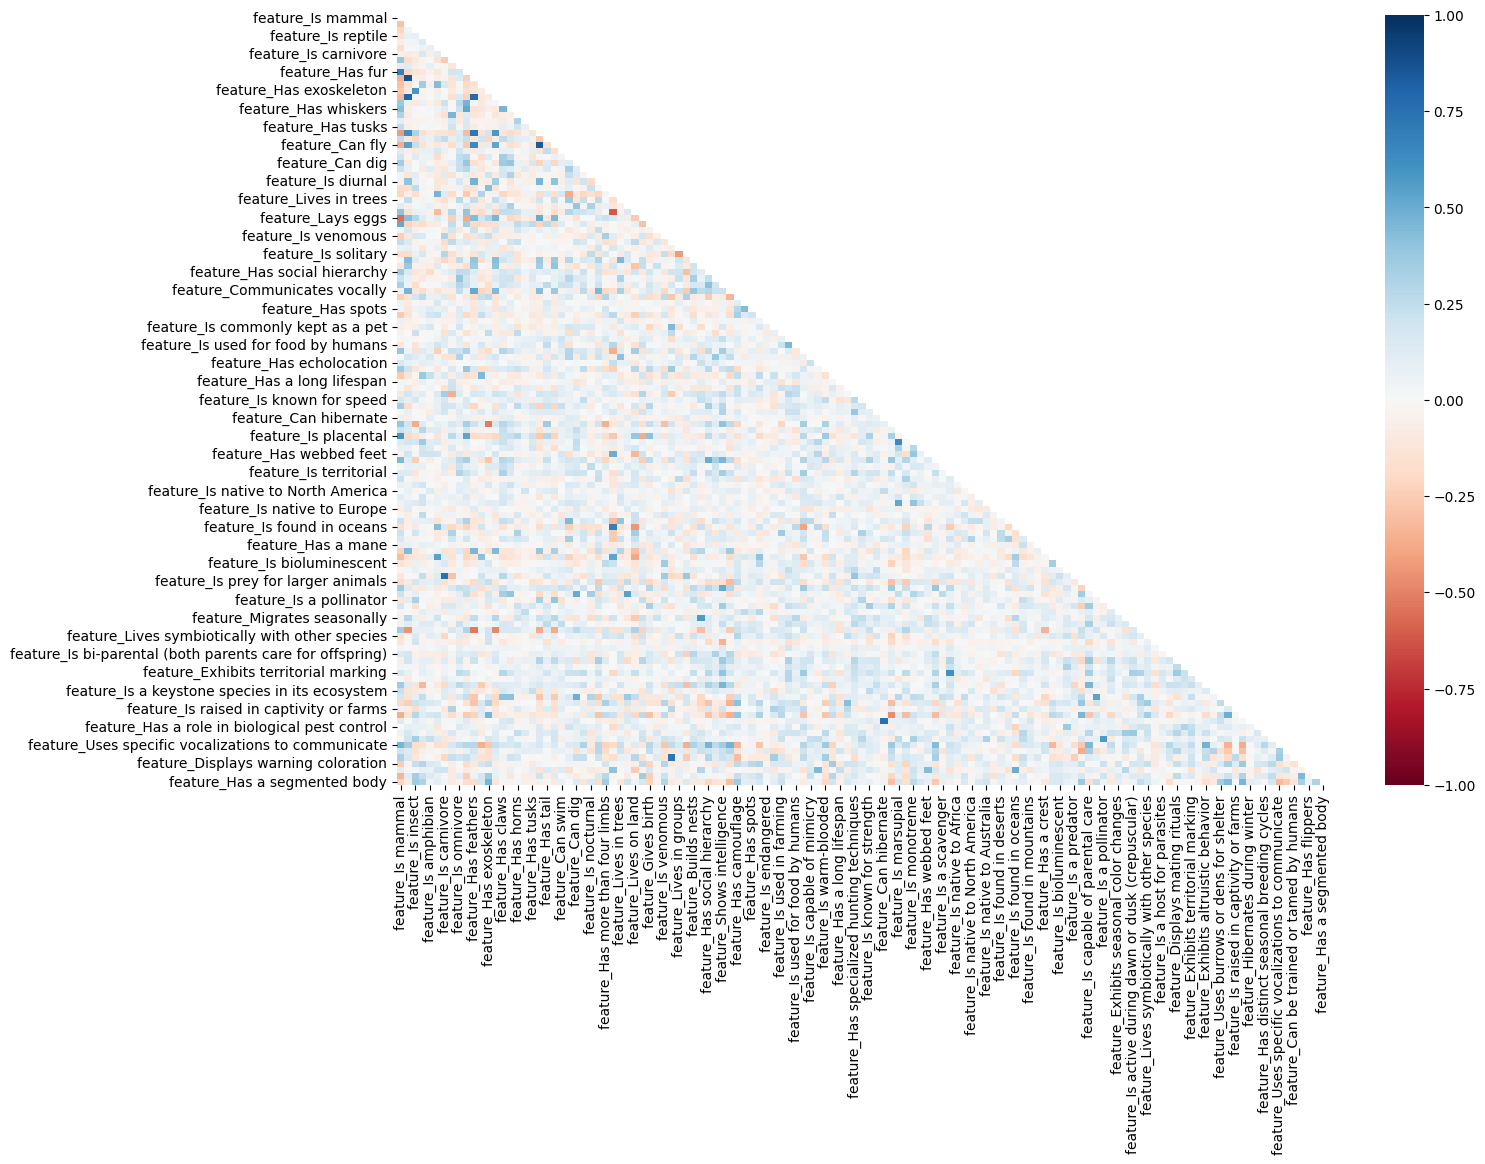

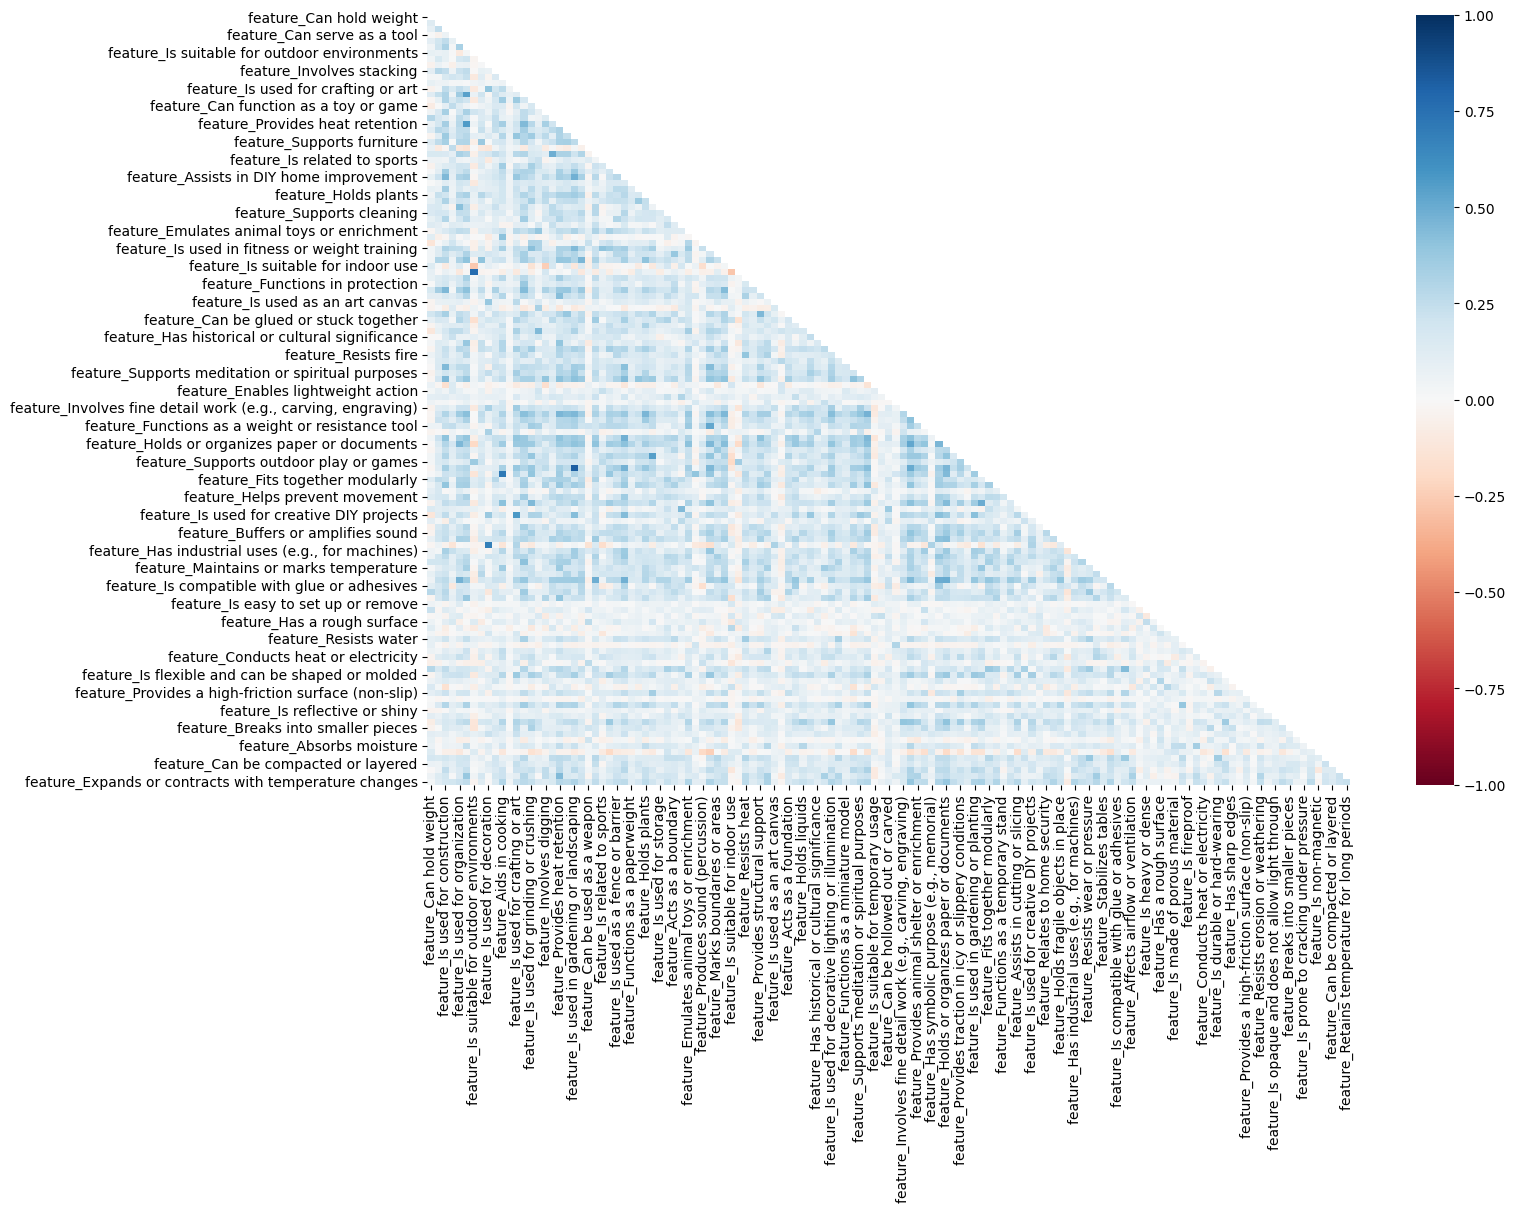

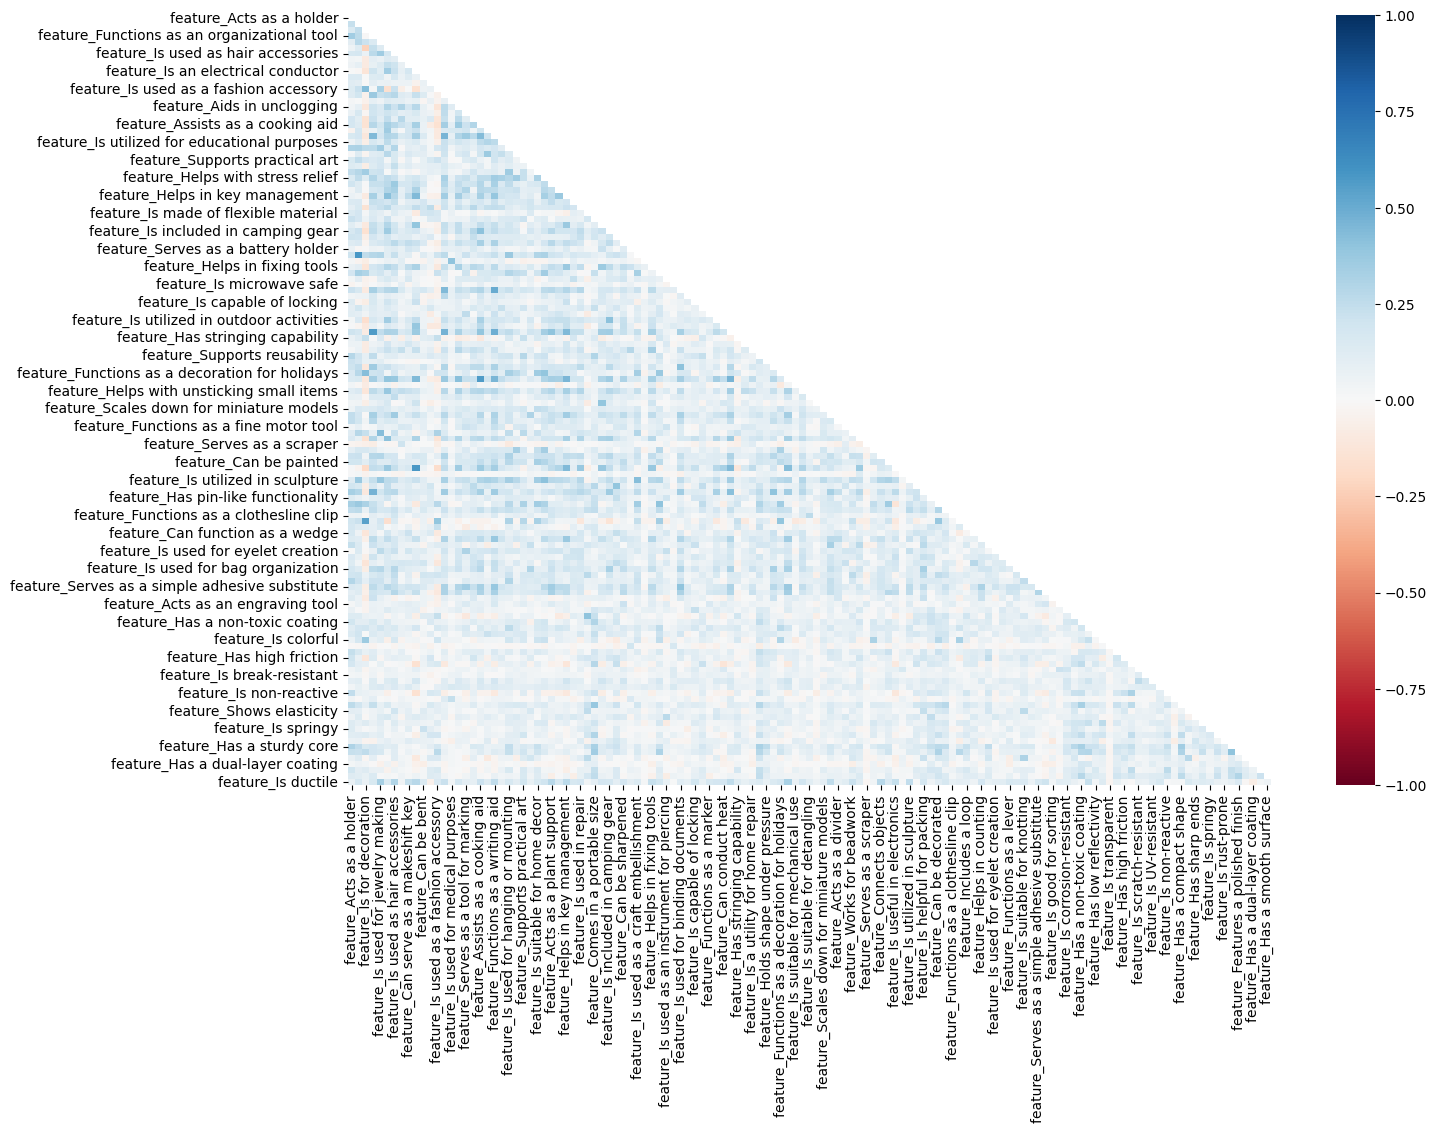

In [8]:
def correlation_matrix(df):
    correlation_matrix = df.corr()
    mask = np.triu(np.ones(correlation_matrix.shape), k=1)  # Upper triangle mask
    corr = correlation_matrix.where(mask == 0)
    plt.figure(figsize=(15, 10))
    sns.heatmap(corr, annot=False, cmap='RdBu', fmt=".1f", mask=np.triu(np.ones_like(corr, dtype=bool)), vmin=-1, vmax=1)
    plt.show()
    return correlation_matrix

vf_featuredf_corr = correlation_matrix(vf_featuredf)
autbrick_featuredf_corr = correlation_matrix(autbrick_featuredf)
autpaperclip_featuredf_corr = correlation_matrix(autpaperclip_featuredf)

In [9]:
# % of correlated features (greater than 0.5 corr)
print(np.mean(vf_featuredf_corr > 0.5),
np.mean(autbrick_featuredf_corr > 0.5),
np.mean(autpaperclip_featuredf_corr > 0.5))

# % of correlated features (less than -0.5 corr)
print(np.mean(vf_featuredf_corr < -0.5),
np.mean(autbrick_featuredf_corr < -0.5),
np.mean(autpaperclip_featuredf_corr < -0.5))

0.011966023932047863 0.009112426035502958 0.008402366863905325
0.000496000992001984 0.0 0.0


In [10]:
def get_highly_correlated_columns(corr, threshold=0.75):
    # List to store highly correlated columns
    highly_correlated = {}
    
    # can change the logic to only keep correlated columns that as least correlated with others
    # if (np.sum(vf_featuredf_corr.loc["feature_Is mammal"].values) - 1)/(len(vf_featuredf_corr.loc["feature_Is mammal"].values) - 1)

    for i, col in enumerate(corr.columns):
        for prev_col in corr.columns[:i]:  # Check only previous columns
            if abs(corr.loc[col, prev_col]) >= threshold:  # Check correlation
                highly_correlated[col] = prev_col
                break
    
    return highly_correlated

high_corr_columns_vf = get_highly_correlated_columns(vf_featuredf_corr)
high_corr_columns_autbrick = get_highly_correlated_columns(autbrick_featuredf_corr)
high_corr_columns_autpaperclip = get_highly_correlated_columns(autpaperclip_featuredf_corr)

In [11]:
print(len(high_corr_columns_vf), len(high_corr_columns_autbrick), len(high_corr_columns_autpaperclip))

5 2 0


In [12]:
remove_columns_vf = [col for col in vf_featuredf.columns if vf_featuredf[col].mean() < 0.1 or vf_featuredf[col].mean() > 0.7]
remove_columns_autbrick = [col for col in autbrick_featuredf.columns if autbrick_featuredf[col].mean() < 0.1 or autbrick_featuredf[col].mean() > 0.7]
remove_columns_autpaperclip = [col for col in autpaperclip_featuredf.columns if autpaperclip_featuredf[col].mean() < 0.1 or autpaperclip_featuredf[col].mean() > 0.7]

In [13]:
remove_columns_vf.extend(list(high_corr_columns_vf.keys()))
remove_columns_autbrick.extend(list(high_corr_columns_autbrick.keys()))
remove_columns_autpaperclip.extend(list(high_corr_columns_autpaperclip.keys()))

In [14]:
print(len(vf_featurecols), len(autbrick_featurecols), len(autpaperclip_featurecols))

127 130 130


## Add features to responses

In [15]:
def add_features_to_responsedf(df, task, featurecols):
    featuredict = pk.load(open(f"{task}_features.pk", "rb"))
    mapped_features = df['response'].map(featuredict)
    mapped_features = mapped_features.apply(lambda x: x if isinstance(x, dict) else {})
    fc = pd.DataFrame(mapped_features.tolist())
    df = pd.concat([df, fc], axis=1)
    df = df.replace({'True': 1, 'True.': 1, 'False': 0, 'False.': 0})
    for col in featurecols:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    df = df.dropna(subset=featurecols)
    if task == "vf":
        df = df[~df["response"].isin(vf_to_remove)]
    return df

data_vf = add_features_to_responsedf(data_vf, "vf", vf_featurecols)
data_autbrick = add_features_to_responsedf(data_autbrick, "autbrick", autbrick_featurecols)
data_autpaperclip = add_features_to_responsedf(data_autpaperclip, "autpaperclip", autpaperclip_featurecols)

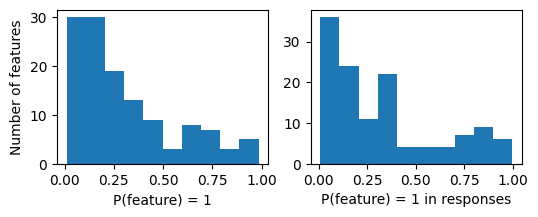

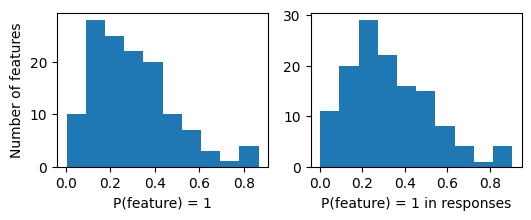

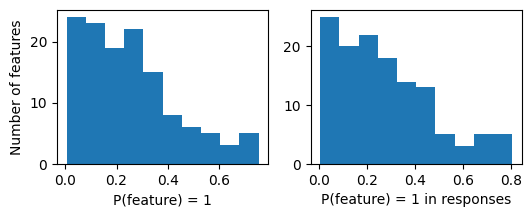

In [16]:
def plot_means(df, featuredf, featurecols):
    fig, ax = plt.subplots(1, 2, figsize=(6,2))
    ax[0].hist(featuredf.mean(axis=0).values);
    ax[0].set_xlabel("P(feature) = 1")
    ax[0].set_ylabel("Number of features")
    ax[1].hist(df[featurecols].mean(axis=0).values);
    ax[1].set_xlabel("P(feature) = 1 in responses")

plot_means(data_vf, vf_featuredf, vf_featurecols)
plot_means(data_autbrick, autbrick_featuredf, autbrick_featurecols)
plot_means(data_autpaperclip, autpaperclip_featuredf, autpaperclip_featurecols)

In [17]:
def find_consecutive_ones(df, feature_col):
    # result = {}
    counts = {}
    for subject in df["pid"].unique():
        subject_data = df[df["pid"] == subject][feature_col].values
        # counts = {}
        current_count = 0
        for value in subject_data:
            if value == 1:
                current_count += 1
            elif current_count > 0:
                counts[current_count] = counts.get(current_count, 0) + 1
                current_count = 0
        # Add the last streak if it ends with a 1
        if current_count > 0:
            counts[current_count] = counts.get(current_count, 0) + 1 
        # result[subject] = counts
    # return result
    return counts

def make_persistance_plots(df, featuredf, featurecols):
    for col in featurecols:
        plt.figure(figsize = (2,2))
        p = df[featurecols].mean(axis=0).loc[col]   # response df
        p_ = featuredf.mean(axis=0).loc[col]        # feature df
        
        print(col, p, p_)

        fco = dict(sorted(find_consecutive_ones(df, col).items()))
        plt.plot(list(fco.keys()), np.array(list(fco.values())) / (np.sum(list(fco.values()))), label = "Data")
        
        x = np.arange(1, list(fco.keys())[-1] + 1)
        geometric_pdf = (p ** x) * (1 - p) 
        plt.plot(x, geometric_pdf, label = "Random")
        
        plt.legend()
        plt.show()

def make_persistance_plots_conditional(df, featuredf, featurecols):
    cols_to_remove = []
    for col in featurecols:
        plt.figure(figsize = (2,2))
        p = df[featurecols].mean(axis=0).loc[col]   # response df
        p_ = featuredf.mean(axis=0).loc[col]        # feature df
        
        print(col, p, p_)

        fco = dict(sorted(find_consecutive_ones(df, col).items()))
        print(fco)
        x = np.array(list(fco.keys()))
        
        data_values = np.array(list(fco.values()))
        observed = data_values / np.sum(data_values)
        plt.plot(x, observed, label = "Data")
        
        geometric_pdf = (p ** (x - 1)) * (1 - p) 
        plt.plot(x, geometric_pdf, label = "Random")

        # expected = geometric_pdf * np.sum(data_values)
        # expected *= np.sum(data_values) / np.sum(expected)

        chi2_stat, p_value = chisquare(data_values, f_exp=geometric_pdf / np.sum(geometric_pdf) * np.sum(data_values))
        print(f"Chi-Square Statistic: {chi2_stat}, p-value: {p_value}")
        if p_value > 0.01:
            cols_to_remove.append(col)
        
        plt.legend()
        plt.show()
    return cols_to_remove

def make_persistance_plots_hazard(df, featuredf, featurecols):
    for col in featurecols:
        plt.figure(figsize = (2,2))
        p = df[featurecols].mean(axis=0).loc[col]   # response df
        p_ = featuredf.mean(axis=0).loc[col]        # feature df
        
        print(col, p, p_)

        fco = dict(sorted(find_consecutive_ones(df, col).items()))

        remaining_population = sum(fco.values())
        hazard_function = []

        for i, freq_i in fco.items():
            hazard_function.append(freq_i / remaining_population)  # Hazard probability for i
            remaining_population -= freq_i

        plt.plot(list(fco.keys()), hazard_function, label = "Data")
        
        x = np.arange(1, list(fco.keys())[-1] + 1)
        geometric_pdf = [(1 - p)] * len(x)
        plt.plot(x, geometric_pdf, label = "Random")
        
        plt.legend()
        plt.show()

feature_Is mammal 0.6428571428571429 0.4763092269326683
{1: 238, 2: 207, 3: 157, 4: 109, 5: 84, 6: 67, 7: 49, 8: 30, 9: 25, 10: 21, 11: 13, 12: 10, 13: 8, 14: 4, 15: 1, 16: 2, 17: 2, 18: 2, 19: 1, 20: 1}
Chi-Square Statistic: 262.137966546883, p-value: 1.0677709258724272e-44


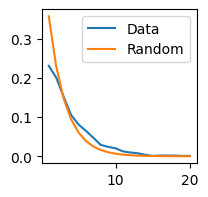

feature_Is bird 0.1279896574014221 0.20199501246882792
{1: 306, 2: 86, 3: 42, 4: 17, 5: 11, 6: 5, 7: 1, 8: 1, 9: 1, 11: 1}
Chi-Square Statistic: 2106053.1496142847, p-value: 0.0


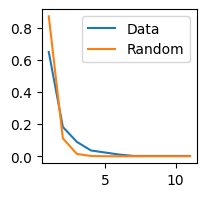

feature_Is insect 0.07659987071751778 0.11471321695760599
{1: 157, 2: 53, 3: 20, 4: 12, 5: 10, 6: 5, 7: 2, 9: 1}
Chi-Square Statistic: 3649760.0155412885, p-value: 0.0


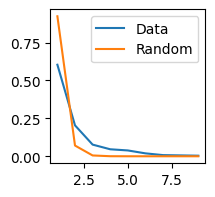

feature_Is reptile 0.05656108597285068 0.10723192019950124
{1: 217, 2: 37, 3: 10, 4: 6, 5: 1}
Chi-Square Statistic: 1290.4193827605632, p-value: 3.9752535126284066e-278


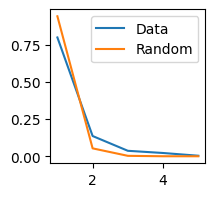

feature_Is amphibian 0.013251454427925016 0.02743142144638404
{1: 53, 2: 13, 3: 1}
Chi-Square Statistic: 254.52930642791353, p-value: 5.366156913290508e-56


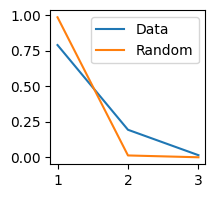

feature_Is fish 0.06641887524240465 0.11471321695760599
{1: 272, 2: 49, 3: 8, 4: 2, 9: 1}
Chi-Square Statistic: 8518734.594734136, p-value: 0.0


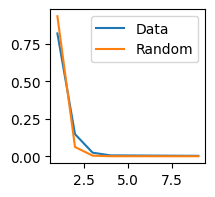

feature_Is carnivore 0.33564964447317386 0.2593516209476309
{1: 505, 2: 354, 3: 113, 4: 75, 5: 20, 6: 6, 7: 9, 8: 1, 9: 2}
Chi-Square Statistic: 321.6485578531703, p-value: 1.0090968541381901e-64


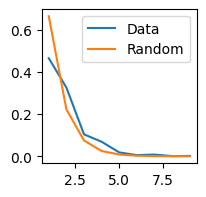

feature_Is herbivore 0.2766645119586296 0.18204488778054864
{1: 554, 2: 247, 3: 98, 4: 39, 5: 16, 6: 10, 7: 6, 8: 4}
Chi-Square Statistic: 501.1866578512232, p-value: 4.455377653524495e-104


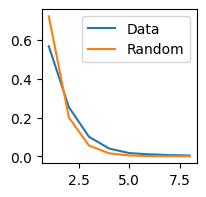

feature_Is omnivore 0.35601163542340014 0.38902743142144636
{1: 822, 2: 319, 3: 127, 4: 46, 5: 21, 6: 7, 7: 2, 8: 1, 9: 1}
Chi-Square Statistic: 13.934368308652306, p-value: 0.0834922024874187


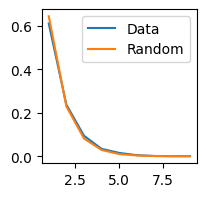

feature_Has fur 0.3947963800904977 0.2967581047381546
{1: 492, 2: 280, 3: 171, 4: 74, 5: 51, 6: 27, 7: 12, 8: 4, 9: 3, 11: 2}
Chi-Square Statistic: 375.8474977734146, p-value: 1.9371579914935688e-75


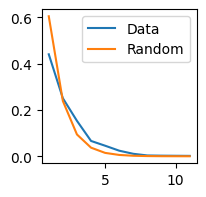

feature_Has feathers 0.12346477052359406 0.16209476309226933
{1: 304, 2: 84, 3: 43, 4: 18, 5: 9, 6: 5, 7: 1, 9: 1}
Chi-Square Statistic: 49747.24679756773, p-value: 0.0


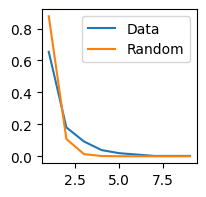

feature_Has scales 0.10892049127343245 0.11471321695760599
{1: 412, 2: 94, 3: 14, 4: 8}
Chi-Square Statistic: 145.49331661379676, p-value: 2.4708370284684927e-31


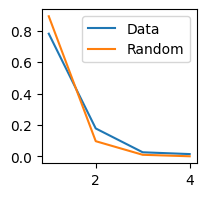

feature_Has exoskeleton 0.07740788623141565 0.10473815461346633
{1: 197, 2: 78, 3: 25, 4: 7, 5: 2, 6: 1, 7: 1}
Chi-Square Statistic: 18672.338160413532, p-value: 0.0


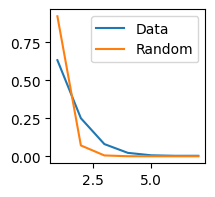

feature_Has beak 0.13332255979314803 0.19950124688279303
{1: 360, 2: 84, 3: 39, 4: 18, 5: 12, 6: 4, 7: 1, 8: 1, 9: 1}
Chi-Square Statistic: 27819.55658212508, p-value: 0.0


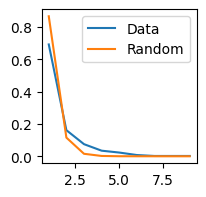

feature_Has claws 0.35423400129282484 0.3915211970074813
{1: 671, 2: 272, 3: 140, 4: 71, 5: 23, 6: 11, 7: 5, 8: 3, 9: 2, 15: 1}
Chi-Square Statistic: 2761.8897374267744, p-value: 0.0


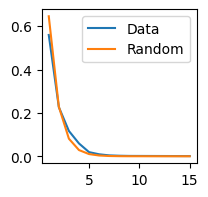

feature_Has whiskers 0.17679379444085327 0.1371571072319202
{1: 548, 2: 151, 3: 48, 4: 21, 5: 2, 6: 1}
Chi-Square Statistic: 162.77530360099135, p-value: 2.534969935918792e-33


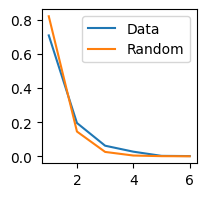

feature_Has horns 0.10148674854557208 0.09725685785536159
{1: 315, 2: 95, 3: 26, 4: 4, 5: 1, 6: 4}
Chi-Square Statistic: 3968.5457600421687, p-value: 0.0


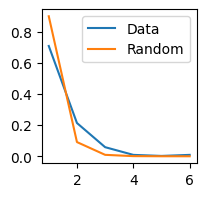

feature_Has antlers 0.011473820297349708 0.00997506234413965
{1: 54, 2: 7, 3: 1}
Chi-Square Statistic: 179.19567730461276, p-value: 1.2250479357571443e-39


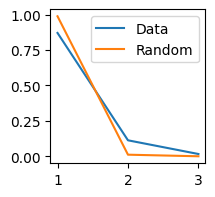

feature_Has tusks 0.08354880413703943 0.059850374064837904
{1: 436, 2: 39, 3: 1}
Chi-Square Statistic: 1.5514149694227053, p-value: 0.4603779553893561


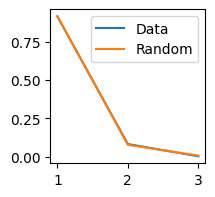

feature_Has wings 0.17194570135746606 0.18952618453865336
{1: 334, 2: 132, 3: 57, 4: 34, 5: 16, 6: 8, 7: 2, 8: 1, 9: 1}
Chi-Square Statistic: 5520.288980697887, p-value: 0.0


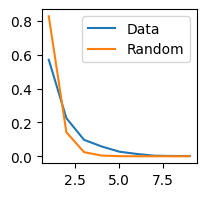

feature_Has tail 0.6360698125404007 0.5311720698254364
{1: 367, 2: 281, 3: 203, 4: 118, 5: 81, 6: 60, 7: 39, 8: 31, 9: 26, 10: 13, 11: 8, 12: 4, 13: 4, 14: 4, 15: 1, 17: 1}
Chi-Square Statistic: 64.08711542129416, p-value: 4.935820498848349e-08


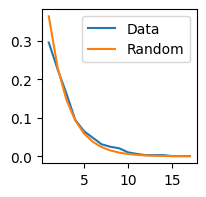

feature_Can fly 0.1195862960568843 0.14214463840399003
{1: 277, 2: 84, 3: 34, 4: 22, 5: 8, 6: 7, 7: 1, 8: 2}
Chi-Square Statistic: 37672.31668428425, p-value: 0.0


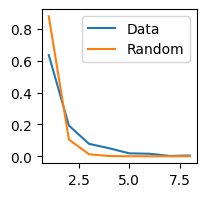

feature_Can swim 0.8225597931480284 0.8229426433915212
{1: 154, 2: 142, 3: 113, 4: 104, 5: 86, 6: 63, 7: 56, 8: 40, 9: 36, 10: 30, 11: 21, 12: 25, 13: 14, 14: 14, 15: 17, 16: 8, 17: 6, 18: 2, 19: 5, 20: 2, 21: 1, 22: 1, 23: 2, 24: 2, 25: 1, 26: 1}
Chi-Square Statistic: 16.781928744795568, p-value: 0.8895507397940092


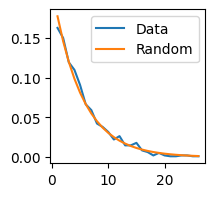

feature_Can climb 0.3721719457013575 0.38154613466334164
{1: 826, 2: 318, 3: 146, 4: 49, 5: 29, 6: 8, 7: 2}
Chi-Square Statistic: 17.792543030559553, p-value: 0.006772103035232815


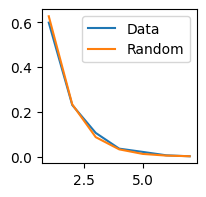

feature_Can dig 0.3138332255979315 0.3117206982543641
{1: 643, 2: 282, 3: 107, 4: 38, 5: 29, 6: 10, 7: 7, 8: 1}
Chi-Square Statistic: 192.7766414299604, p-value: 3.8802643904638505e-38


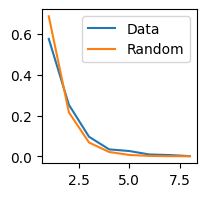

feature_Can jump 0.3506787330316742 0.2593516209476309
{1: 789, 2: 352, 3: 114, 4: 57, 5: 16, 6: 2, 7: 1, 8: 1}
Chi-Square Statistic: 28.10593505638779, p-value: 0.00021038170894240745


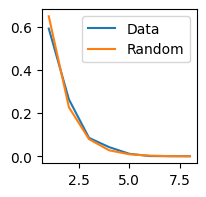

feature_Is nocturnal 0.14221073044602456 0.10723192019950124
{1: 505, 2: 114, 3: 38, 4: 7, 5: 1}
Chi-Square Statistic: 101.558664565928, p-value: 4.5811302579026175e-21


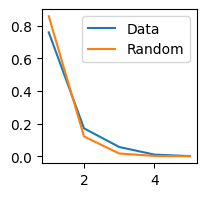

feature_Is diurnal 0.3456690368455074 0.26683291770573564
{1: 604, 2: 322, 3: 121, 4: 59, 5: 33, 6: 11, 7: 4, 8: 3, 9: 1}
Chi-Square Statistic: 164.19781115692874, p-value: 2.117011154085478e-31


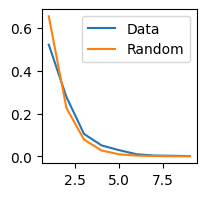

feature_Has more than four limbs 0.13202973497091144 0.12967581047381546
{1: 440, 2: 140, 3: 23, 4: 7}
Chi-Square Statistic: 133.33735461563387, p-value: 1.0322824530312378e-28


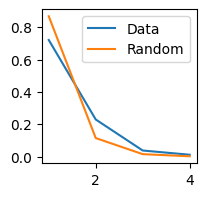

feature_Lives in water 0.17695539754363285 0.24937655860349128
{1: 341, 2: 90, 3: 57, 4: 28, 5: 23, 6: 10, 7: 4, 8: 6, 9: 2, 10: 1, 12: 1}
Chi-Square Statistic: 444915.9642484267, p-value: 0.0


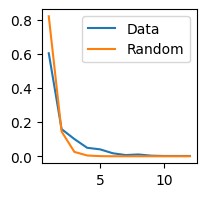

feature_Lives in trees 0.08144796380090498 0.12468827930174564
{1: 368, 2: 48, 3: 8, 5: 2, 6: 1}
Chi-Square Statistic: 957.373087870214, p-value: 6.166417756437498e-206


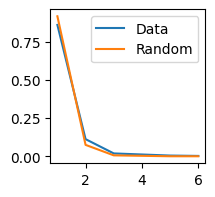

feature_Lives underground 0.06900452488687783 0.06982543640897755
{1: 186, 2: 84, 3: 19, 4: 4}
Chi-Square Statistic: 665.1069809086108, p-value: 7.724875268086731e-144


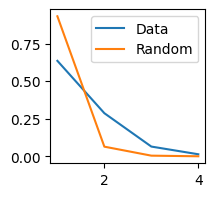

feature_Lives on land 0.7348093083387202 0.600997506234414
{1: 237, 2: 156, 3: 120, 4: 79, 5: 85, 6: 57, 7: 53, 8: 47, 9: 34, 10: 27, 11: 24, 12: 25, 13: 12, 14: 8, 15: 8, 16: 3, 17: 4, 18: 2, 19: 2, 21: 1, 23: 3}
Chi-Square Statistic: 127.66456431178113, p-value: 1.0674558028968656e-17


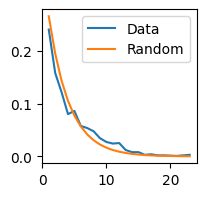

feature_Lays eggs 0.2819974143503555 0.3341645885286783
{1: 587, 2: 197, 3: 94, 4: 45, 5: 30, 6: 11, 7: 4, 8: 5, 9: 2}
Chi-Square Statistic: 741.8550325988035, p-value: 6.941600248062665e-155


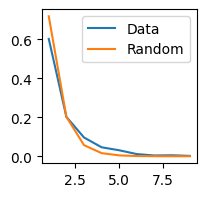

feature_Gives birth 0.28603749191984484 0.2344139650872818
{1: 605, 2: 264, 3: 126, 4: 34, 5: 12, 6: 7, 7: 3}
Chi-Square Statistic: 170.40844637746295, p-value: 3.6843557890246946e-34


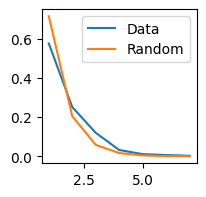

feature_Has a long neck 0.08532643826761474 0.057356608478802994
{1: 401, 2: 57, 3: 3, 4: 1}
Chi-Square Statistic: 15.33889125608677, p-value: 0.0015487933739877927


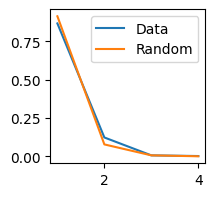

feature_Is venomous 0.07692307692307693 0.10224438902743142
{1: 270, 2: 57, 3: 24, 4: 2, 5: 1, 7: 1}
Chi-Square Statistic: 15137.052083066481, p-value: 0.0


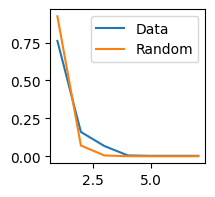

feature_Is domesticated 0.3156108597285068 0.18703241895261846
{1: 352, 2: 206, 3: 121, 4: 82, 5: 37, 6: 24, 7: 10, 8: 6, 9: 2, 10: 1, 11: 1, 12: 1}
Chi-Square Statistic: 2026.6171045642166, p-value: 0.0


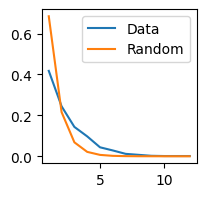

feature_Lives in groups 0.32870071105365223 0.3491271820448878
{1: 807, 2: 313, 3: 107, 4: 40, 5: 11, 6: 6, 7: 3, 8: 1}
Chi-Square Statistic: 18.28517364412351, p-value: 0.010747512098043767


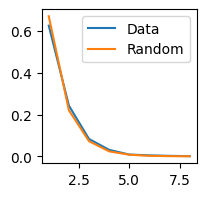

feature_Is solitary 0.3329023917259211 0.36658354114713215
{1: 960, 2: 301, 3: 90, 4: 33, 5: 10, 6: 3, 7: 4}
Chi-Square Statistic: 9.075360627493, p-value: 0.16938399202172225


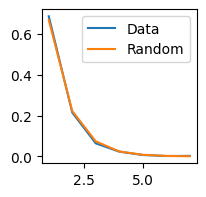

feature_Builds nests 0.2398190045248869 0.26433915211970077
{1: 688, 2: 169, 3: 79, 4: 28, 5: 13, 6: 5, 7: 2}
Chi-Square Statistic: 167.56011658060402, p-value: 1.4804741714515228e-33


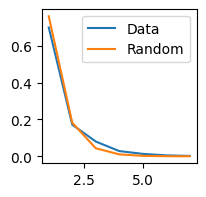

feature_Is migratory 0.14124111182934712 0.1770573566084788
{1: 435, 2: 127, 3: 36, 4: 8, 5: 6, 6: 1, 9: 1}
Chi-Square Statistic: 12307.819134117548, p-value: 0.0


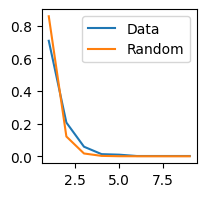

feature_Has social hierarchy 0.8915643180349063 0.7556109725685786
{1: 93, 2: 76, 3: 47, 4: 59, 5: 44, 6: 35, 7: 45, 8: 33, 9: 29, 10: 38, 11: 20, 12: 26, 13: 21, 14: 23, 15: 12, 16: 17, 17: 17, 18: 6, 19: 12, 20: 6, 21: 13, 22: 8, 23: 4, 24: 4, 25: 1, 26: 1, 27: 2, 28: 2, 29: 1, 30: 1, 31: 1, 33: 1}
Chi-Square Statistic: 41.252542756003066, p-value: 0.10314977531995637


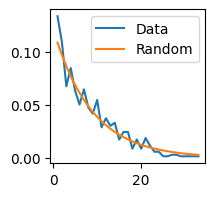

feature_Uses tools 0.19311570782159018 0.19451371571072318
{1: 627, 2: 135, 3: 45, 4: 23, 5: 10, 6: 1, 7: 1, 8: 1}
Chi-Square Statistic: 347.8023287005378, p-value: 3.640123669887117e-71


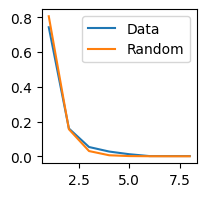

feature_Shows intelligence 0.9665481577246283 0.8778054862842892
{1: 23, 2: 19, 3: 17, 4: 21, 5: 15, 6: 17, 7: 16, 8: 16, 9: 12, 10: 16, 11: 10, 12: 9, 13: 11, 14: 11, 15: 12, 16: 9, 17: 11, 18: 11, 19: 13, 20: 9, 21: 14, 22: 14, 23: 8, 24: 4, 25: 6, 26: 9, 27: 6, 28: 14, 29: 6, 30: 8, 31: 5, 32: 5, 33: 5, 34: 2, 35: 4, 36: 5, 37: 4, 38: 4, 47: 1}
Chi-Square Statistic: 28.933959113666976, p-value: 0.8550395348475978


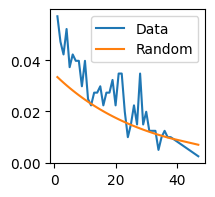

feature_Communicates vocally 0.32563025210084034 0.27680798004987534
{1: 695, 2: 322, 3: 103, 4: 36, 5: 14, 6: 15, 7: 5, 9: 2, 10: 1}
Chi-Square Statistic: 167.44839796246094, p-value: 4.4166851436722886e-32


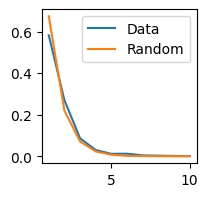

feature_Has camouflage 0.27213962508080153 0.40399002493765584
{1: 616, 2: 234, 3: 93, 4: 40, 5: 9, 6: 8, 7: 6, 8: 1, 9: 2}
Chi-Square Statistic: 441.2759482109659, p-value: 2.7349740773884087e-90


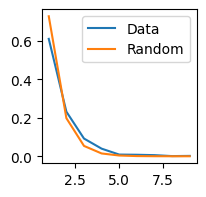

feature_Has stripes 0.0850032320620556 0.04987531172069826
{1: 390, 2: 56, 3: 8}
Chi-Square Statistic: 21.98601995673559, p-value: 1.6818855018341946e-05


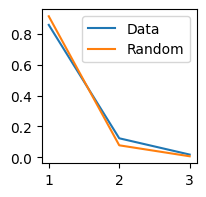

feature_Has spots 0.1255656108597285 0.12468827930174564
{1: 505, 2: 96, 3: 20, 4: 5}
Chi-Square Statistic: 43.218529795423926, p-value: 2.211626337275464e-09


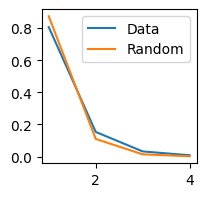

feature_Can change color 0.0861344537815126 0.15211970074812967
{1: 336, 2: 62, 3: 14, 4: 4, 5: 3}
Chi-Square Statistic: 553.7728682851814, p-value: 1.561769308447338e-118


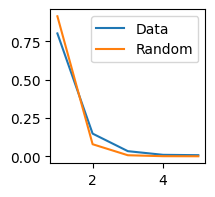

feature_Is endangered 0.006464124111182934 0.034912718204488775
{1: 38, 2: 1}
Chi-Square Statistic: 2.257287056834569, p-value: 0.13298685340681757


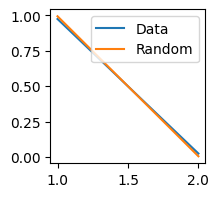

feature_Is commonly kept as a pet 0.35180995475113125 0.2194513715710723
{1: 533, 2: 285, 3: 124, 4: 77, 5: 40, 6: 17, 7: 7, 8: 3, 9: 1, 10: 1}
Chi-Square Statistic: 314.5311341523966, p-value: 2.1513775707997945e-62


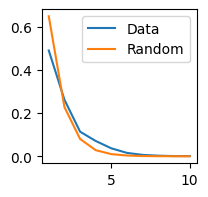

feature_Is used in farming 0.3136716224951519 0.2892768079800499
{1: 563, 2: 196, 3: 96, 4: 67, 5: 40, 6: 19, 7: 6, 8: 7, 9: 2}
Chi-Square Statistic: 769.9626903245223, p-value: 6.113397235050711e-161


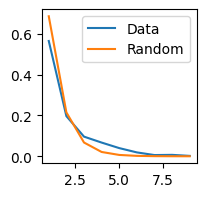

feature_Is hunted by humans 0.732546864899806 0.6982543640897756
{1: 282, 2: 223, 3: 186, 4: 129, 5: 90, 6: 64, 7: 53, 8: 34, 9: 20, 10: 18, 11: 12, 12: 16, 13: 15, 14: 6, 15: 7, 16: 3, 17: 1, 18: 3, 20: 1, 22: 1, 25: 1}
Chi-Square Statistic: 27.289499272039617, p-value: 0.12731386799747152


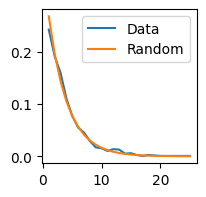

feature_Is used for food by humans 0.5072721396250808 0.43640897755610975
{1: 596, 2: 296, 3: 183, 4: 109, 5: 68, 6: 40, 7: 26, 8: 10, 9: 4, 10: 4, 11: 1, 12: 2, 13: 1}
Chi-Square Statistic: 83.43396376514494, p-value: 9.096133808772181e-13


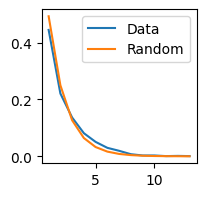

feature_Is found in zoos 0.8243374272786037 0.7281795511221946
{1: 149, 2: 88, 3: 75, 4: 54, 5: 53, 6: 51, 7: 43, 8: 43, 9: 31, 10: 30, 11: 31, 12: 25, 13: 17, 14: 9, 15: 16, 16: 14, 17: 10, 18: 11, 19: 6, 20: 4, 21: 6, 22: 6, 23: 2, 25: 2, 26: 1, 27: 1, 28: 1, 29: 2, 33: 1}
Chi-Square Statistic: 67.94899558418574, p-value: 3.5818831024906456e-05


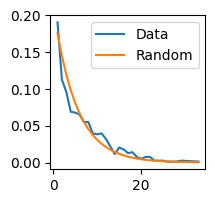

feature_Is capable of mimicry 0.12394957983193278 0.18204488778054864
{1: 489, 2: 81, 3: 29, 4: 6, 5: 1}
Chi-Square Statistic: 90.804880668128, p-value: 8.882015341081173e-19


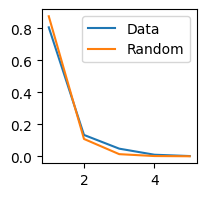

feature_Has echolocation 0.03409825468648998 0.02493765586034913
{1: 132, 2: 38, 3: 1}
Chi-Square Statistic: 196.07739125672185, p-value: 2.6444507039624815e-43


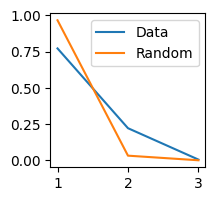

feature_Is warm-blooded 0.3393665158371041 0.2743142144638404
{1: 647, 2: 342, 3: 140, 4: 51, 5: 24, 6: 3, 7: 1}
Chi-Square Statistic: 102.11592570952854, p-value: 9.076387781657982e-20


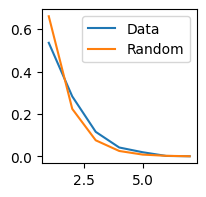

feature_Is cold-blooded 0.08775048480930833 0.0798004987531172
{1: 340, 2: 67, 3: 13, 4: 5, 5: 2}
Chi-Square Statistic: 325.60865577874847, p-value: 3.2307558530023044e-69


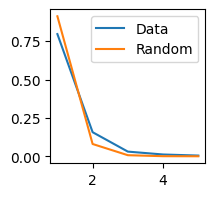

feature_Has a long lifespan 0.11813186813186813 0.10972568578553615
{1: 476, 2: 111, 3: 11}
Chi-Square Statistic: 44.800780069176895, p-value: 1.8691072217715316e-10


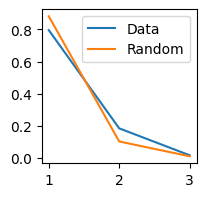

feature_Is capable of regrowth 0.4836780866192631 0.49875311720698257
{1: 649, 2: 345, 3: 180, 4: 107, 5: 42, 6: 31, 7: 21, 8: 9, 9: 2, 10: 3, 11: 1, 12: 1}
Chi-Square Statistic: 49.776010092230656, p-value: 6.867254551489006e-07


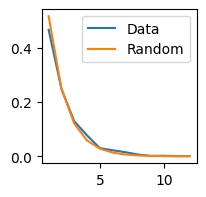

feature_Has specialized hunting techniques 0.7194570135746606 0.683291770573566
{1: 282, 2: 216, 3: 168, 4: 140, 5: 99, 6: 70, 7: 39, 8: 43, 9: 19, 10: 20, 11: 13, 12: 9, 13: 13, 14: 10, 15: 4, 16: 2, 17: 2, 19: 1, 20: 2, 26: 1}
Chi-Square Statistic: 45.399162182434054, p-value: 0.0006024692047436112


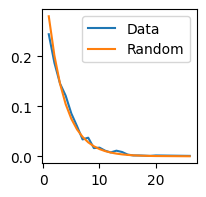

feature_Is known for speed 0.22899159663865545 0.2194513715710723
{1: 690, 2: 213, 3: 66, 4: 19, 5: 3, 6: 2}
Chi-Square Statistic: 47.82986979312051, p-value: 3.84758447427677e-09


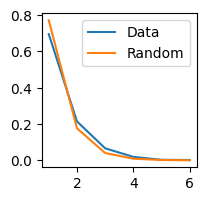

feature_Is known for strength 0.5557530704589528 0.47381546134663344
{1: 649, 2: 314, 3: 217, 4: 128, 5: 66, 6: 36, 7: 23, 8: 16, 9: 7, 10: 3, 11: 3, 12: 1, 13: 2}
Chi-Square Statistic: 18.300204677580616, p-value: 0.10687466609639565


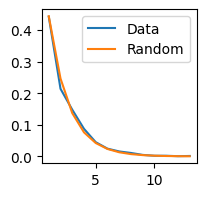

feature_Has a specialized diet 0.8760504201680672 0.7930174563591023
{1: 109, 2: 123, 3: 83, 4: 81, 5: 63, 6: 63, 7: 45, 8: 37, 9: 38, 10: 42, 11: 21, 12: 22, 13: 31, 14: 13, 15: 14, 16: 6, 17: 8, 18: 7, 19: 6, 20: 8, 21: 5, 22: 4, 23: 4, 24: 2, 25: 1, 26: 1, 27: 1, 28: 1, 33: 2}
Chi-Square Statistic: 46.464736584244974, p-value: 0.015592777637900259


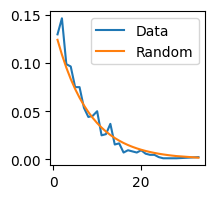

feature_Can hibernate 0.015675500969618616 0.017456359102244388
{1: 95, 2: 1}
Chi-Square Statistic: 0.1590126112895595, p-value: 0.690067212971156


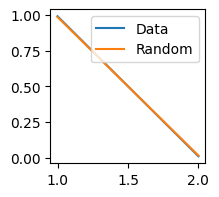

feature_Has a backbone 0.8529411764705882 0.7655860349127181
{1: 94, 2: 84, 3: 74, 4: 49, 5: 55, 6: 51, 7: 43, 8: 29, 9: 21, 10: 41, 11: 24, 12: 21, 13: 23, 14: 17, 15: 19, 16: 9, 17: 14, 18: 11, 19: 6, 20: 11, 21: 7, 22: 2, 23: 1, 24: 3, 25: 2, 26: 2, 27: 1, 28: 2, 30: 2, 31: 1, 32: 1, 39: 1}
Chi-Square Statistic: 49.62030945722692, p-value: 0.018283778906246634


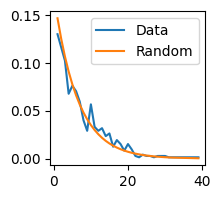

feature_Is marsupial 0.02165481577246283 0.0798004987531172
{1: 97, 2: 14, 3: 3}
Chi-Square Statistic: 223.5939500772445, p-value: 2.8002102904299097e-49


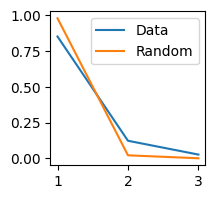

feature_Is placental 0.3894634776987718 0.27680798004987534
{1: 555, 2: 268, 3: 158, 4: 82, 5: 42, 6: 19, 7: 13, 8: 8, 9: 3, 11: 1}
Chi-Square Statistic: 294.4912083944818, p-value: 3.845260607385035e-58


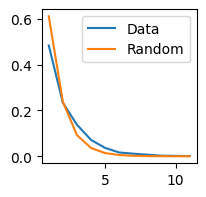

feature_Is monotreme 0.007272139625080802 0.04488778054862843
{1: 45}
Chi-Square Statistic: 0.0, p-value: nan


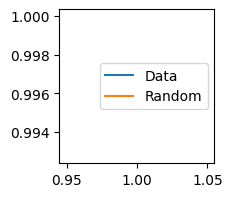

feature_Is flightless 0.19844861021331608 0.1546134663341646
{1: 784, 2: 152, 3: 44, 4: 2}
Chi-Square Statistic: 8.365237573070432, p-value: 0.03903668636758953


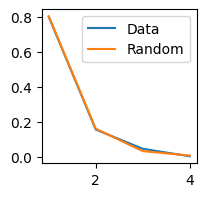

feature_Has webbed feet 0.1389786683904331 0.12718204488778054
{1: 417, 2: 101, 3: 41, 4: 16, 5: 6, 6: 4}
Chi-Square Statistic: 1072.2724322523425, p-value: 1.3504882360894487e-229


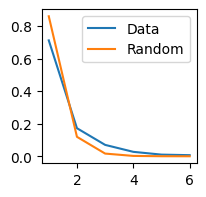

feature_Is known for intelligence 0.8127020038784745 0.6483790523690773
{1: 186, 2: 128, 3: 103, 4: 85, 5: 65, 6: 63, 7: 53, 8: 56, 9: 30, 10: 41, 11: 19, 12: 18, 13: 17, 14: 17, 15: 7, 16: 11, 17: 8, 18: 1, 19: 2, 20: 1, 21: 3, 22: 3, 23: 3, 24: 1, 25: 1, 26: 1, 27: 1, 28: 1, 31: 1}
Chi-Square Statistic: 33.787193531786635, p-value: 0.20796766548557372


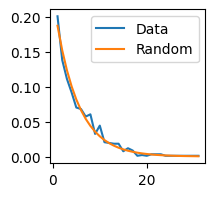

feature_Is a scavenger 0.05235940530058177 0.0798004987531172
{1: 276, 2: 18, 3: 4}
Chi-Square Statistic: 14.282272720681297, p-value: 0.0007918517560765202


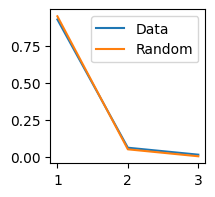

feature_Is territorial 0.7559793148028442 0.685785536159601
{1: 242, 2: 212, 3: 137, 4: 138, 5: 86, 6: 58, 7: 60, 8: 37, 9: 28, 10: 30, 11: 27, 12: 12, 13: 8, 14: 8, 15: 10, 16: 4, 17: 1, 18: 3, 19: 1, 21: 2}
Chi-Square Statistic: 29.14315152796049, p-value: 0.06376651783574269


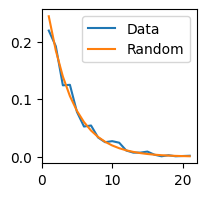

feature_Is native to Africa 0.16483516483516483 0.1172069825436409
{1: 450, 2: 157, 3: 52, 4: 13, 5: 6, 6: 3}
Chi-Square Statistic: 395.05330399734595, p-value: 3.4543088206848874e-83


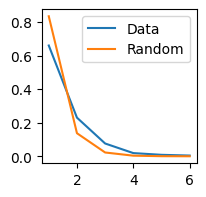

feature_Is native to Asia 0.23529411764705882 0.23690773067331672
{1: 797, 2: 207, 3: 52, 4: 16, 5: 5}
Chi-Square Statistic: 7.6705079192386485, p-value: 0.1044214351754277


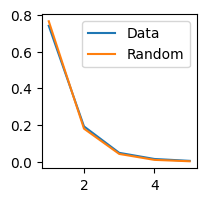

feature_Is native to North America 0.07482223658694247 0.1172069825436409
{1: 351, 2: 41, 3: 10}
Chi-Square Statistic: 37.505250180117486, p-value: 7.175272549287629e-09


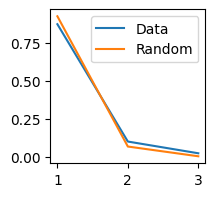

feature_Is native to South America 0.03959276018099547 0.09975062344139651
{1: 204, 2: 17, 3: 1, 4: 1}
Chi-Square Statistic: 83.60197745888595, p-value: 5.178622241776296e-18


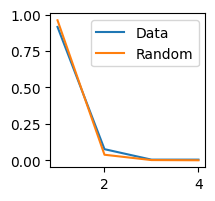

feature_Is native to Australia 0.053652230122818355 0.08977556109725686
{1: 265, 2: 26, 3: 5}
Chi-Square Statistic: 30.630617765353836, p-value: 2.2317516452557846e-07


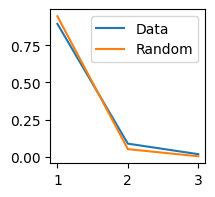

feature_Is native to Europe 0.0728829993535876 0.11970074812967581
{1: 306, 2: 60, 3: 7, 4: 1}
Chi-Square Statistic: 72.5379787638269, p-value: 1.2208682653019177e-15


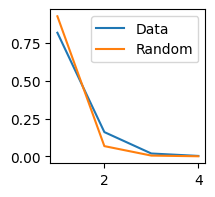

feature_Is found in deserts 0.06900452488687783 0.08728179551122195
{1: 354, 2: 29, 3: 5}
Chi-Square Statistic: 7.062686269043809, p-value: 0.029265581844233442


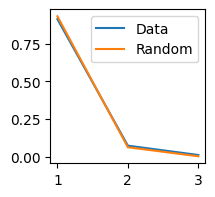

feature_Is found in forests 0.23254686489980608 0.286783042394015
{1: 614, 2: 203, 3: 86, 4: 23, 5: 9, 6: 4}
Chi-Square Statistic: 149.11089468318005, p-value: 2.064293764046177e-30


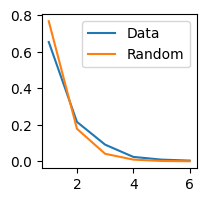

feature_Is found in oceans 0.1486748545572075 0.20199501246882792
{1: 265, 2: 68, 3: 55, 4: 35, 5: 14, 6: 11, 7: 5, 8: 4, 11: 1}
Chi-Square Statistic: 523933.51335766475, p-value: 0.0


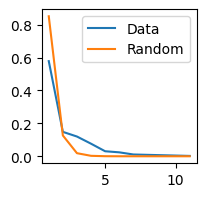

feature_Is found in grasslands 0.36182934712346476 0.24937655860349128
{1: 663, 2: 301, 3: 140, 4: 63, 5: 32, 6: 14, 7: 6, 8: 2}
Chi-Square Statistic: 107.88054741383259, p-value: 2.5261487915940194e-20


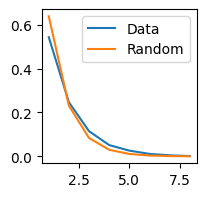

feature_Is found in mountains 0.14285714285714285 0.18952618453865336
{1: 538, 2: 115, 3: 28, 4: 3, 5: 4}
Chi-Square Statistic: 95.27848982497603, p-value: 9.943187675192672e-20


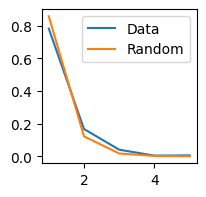

feature_Has a mane 0.057530704589528116 0.02743142144638404
{1: 326, 2: 15}
Chi-Square Statistic: 0.7187337745937395, p-value: 0.3965595683565384


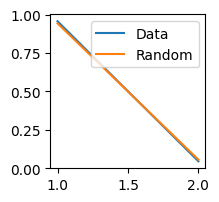

feature_Has a crest 0.09356819650937298 0.18204488778054864
{1: 361, 2: 71, 3: 14, 4: 6, 5: 2}
Chi-Square Statistic: 281.5951593759745, p-value: 1.0093851106511255e-59


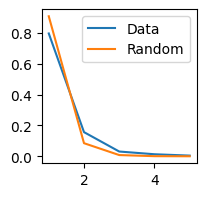

feature_Has gills 0.06237879767291532 0.08977556109725686
{1: 239, 2: 44, 3: 17, 4: 2}
Chi-Square Statistic: 329.8157049760056, p-value: 3.497971056374569e-71


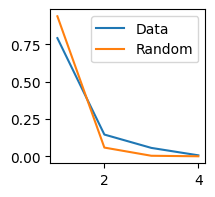

feature_Is bioluminescent 0.030866192630898515 0.032418952618453865
{1: 169, 2: 11}
Chi-Square Statistic: 6.0206440254985045, p-value: 0.014139486041667823


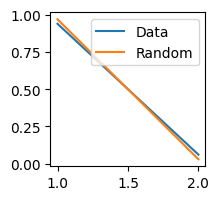

feature_Is used in scientific research 0.986748545572075 0.9625935162094763
{1: 7, 2: 7, 3: 9, 4: 4, 5: 12, 6: 6, 7: 5, 8: 9, 9: 6, 10: 6, 11: 7, 12: 5, 13: 6, 14: 4, 15: 9, 16: 6, 17: 5, 18: 7, 19: 7, 20: 8, 21: 12, 22: 8, 23: 10, 24: 5, 25: 10, 26: 10, 27: 16, 28: 7, 29: 7, 30: 10, 31: 13, 32: 8, 33: 10, 34: 4, 35: 6, 36: 7, 37: 2, 38: 4, 40: 2, 42: 3, 43: 1, 44: 1, 45: 1, 46: 1, 47: 1, 56: 1}
Chi-Square Statistic: 79.47019740363915, p-value: 0.0011585962452302508


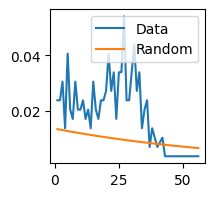

feature_Is a predator 0.33387201034259856 0.30174563591022446
{1: 706, 2: 276, 3: 119, 4: 63, 5: 21, 6: 7, 7: 6, 10: 1}
Chi-Square Statistic: 118.81208372124226, p-value: 1.3540443666055536e-22


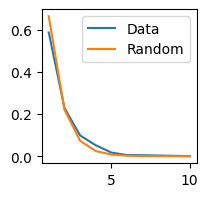

feature_Is prey for larger animals 0.34615384615384615 0.46384039900249374
{1: 620, 2: 264, 3: 127, 4: 72, 5: 30, 6: 11, 7: 6, 8: 5, 9: 3}
Chi-Square Statistic: 258.17570009888806, p-value: 3.1804998413989034e-51


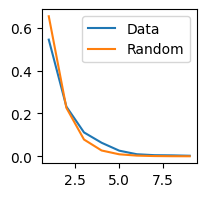

feature_Is capable of parental care 0.8687782805429864 0.770573566084788
{1: 112, 2: 90, 3: 87, 4: 81, 5: 74, 6: 72, 7: 48, 8: 49, 9: 32, 10: 30, 11: 34, 12: 13, 13: 18, 14: 19, 15: 11, 16: 9, 17: 13, 18: 5, 19: 6, 20: 3, 21: 2, 22: 6, 23: 5, 24: 2, 25: 2, 26: 3, 30: 1, 31: 2}
Chi-Square Statistic: 32.51394369835346, p-value: 0.21358462603037504


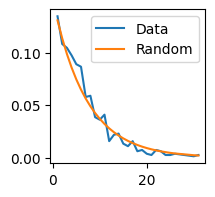

feature_Lives in a burrow 0.13122171945701358 0.16209476309226933
{1: 402, 2: 114, 3: 46, 4: 8, 5: 1, 7: 1}
Chi-Square Statistic: 657.6709661076322, p-value: 6.956256909300941e-140


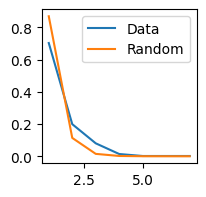

feature_Is a pollinator 0.03765352294764059 0.034912718204488775
{1: 132, 2: 18, 3: 9, 4: 7, 5: 2}
Chi-Square Statistic: 18331.88618627903, p-value: 0.0


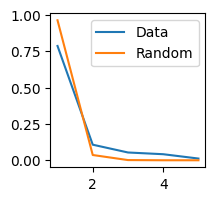

feature_Can tolerate extreme temperatures 0.5518745959922431 0.486284289276808
{1: 432, 2: 278, 3: 179, 4: 114, 5: 74, 6: 53, 7: 32, 8: 19, 9: 7, 10: 11, 11: 5, 12: 6, 13: 2, 14: 2, 16: 1}
Chi-Square Statistic: 198.30186546175884, p-value: 1.220566337260278e-34


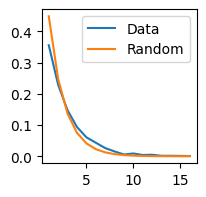

feature_Exhibits seasonal color changes 0.02068519715578539 0.03740648379052369
{1: 114, 2: 7}
Chi-Square Statistic: 8.608831175508984, p-value: 0.0033453691816679085


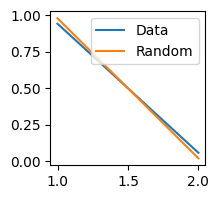

feature_Migrates seasonally 0.3434065934065934 0.35910224438902744
{1: 669, 2: 283, 3: 124, 4: 41, 5: 29, 6: 11, 7: 6, 8: 6, 9: 3, 11: 1, 15: 1}
Chi-Square Statistic: 4361.760749141828, p-value: 0.0


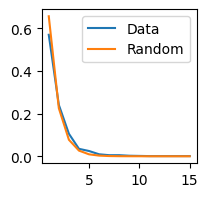

feature_Is active during dawn or dusk (crepuscular) 0.4914350355526826 0.5062344139650873
{1: 814, 2: 365, 3: 177, 4: 81, 5: 50, 6: 23, 7: 13, 8: 4, 9: 6, 10: 2, 11: 3, 12: 2}
Chi-Square Statistic: 27.832829076932867, p-value: 0.003433721013249833


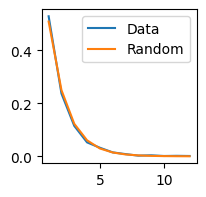

feature_Produces pheromones for communication 0.8236910148674854 0.6932668329177057
{1: 148, 2: 108, 3: 96, 4: 66, 5: 62, 6: 65, 7: 34, 8: 28, 9: 42, 10: 31, 11: 19, 12: 31, 13: 22, 14: 11, 15: 12, 16: 10, 17: 12, 18: 8, 19: 8, 20: 6, 21: 3, 22: 1, 23: 2, 24: 2, 25: 2, 26: 1, 27: 1, 29: 1, 39: 1}
Chi-Square Statistic: 53.26584300358473, p-value: 0.002732770552634568


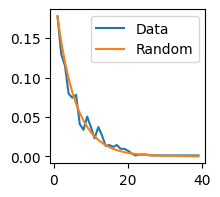

feature_Lives symbiotically with other species 0.6405946994182288 0.6109725685785536
{1: 427, 2: 263, 3: 185, 4: 119, 5: 88, 6: 57, 7: 31, 8: 26, 9: 15, 10: 13, 11: 12, 12: 6, 13: 6, 14: 6, 15: 2, 16: 2, 17: 2, 18: 1, 28: 1}
Chi-Square Statistic: 425.32972359405767, p-value: 4.71454465024324e-79


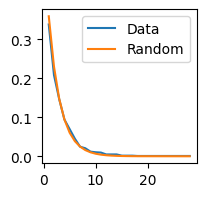

feature_Is a parasite 0.007756948933419522 0.017456359102244388
{1: 46, 2: 1}
Chi-Square Statistic: 1.1346887363783482, p-value: 0.2867774282037366


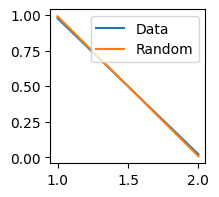

feature_Is a host for parasites 0.9980607627666451 0.9850374064837906
{1: 3, 3: 4, 4: 1, 5: 1, 6: 2, 7: 3, 8: 2, 9: 3, 10: 1, 11: 2, 12: 1, 13: 1, 14: 3, 15: 5, 16: 2, 17: 2, 18: 2, 19: 4, 20: 4, 21: 12, 22: 5, 23: 9, 24: 7, 25: 12, 26: 8, 27: 13, 28: 12, 29: 6, 30: 8, 31: 17, 32: 9, 33: 10, 34: 8, 35: 7, 36: 9, 37: 5, 38: 8, 39: 3, 40: 3, 42: 5, 43: 1, 44: 1, 45: 2, 46: 1, 47: 1, 50: 1, 56: 1}
Chi-Square Statistic: 153.11931968301784, p-value: 1.95828772656481e-13


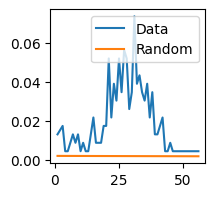

feature_Is bi-parental (both parents care for offspring) 0.17937944408532644 0.16458852867830423
{1: 641, 2: 163, 3: 36, 4: 5, 5: 3}
Chi-Square Statistic: 31.719501646407874, p-value: 2.182975617090667e-06


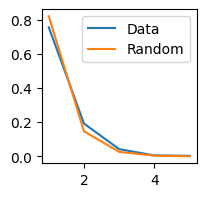

feature_Displays mating rituals 0.755656108597285 0.6658354114713217
{1: 224, 2: 150, 3: 122, 4: 97, 5: 76, 6: 68, 7: 57, 8: 22, 9: 37, 10: 25, 11: 24, 12: 18, 13: 10, 14: 10, 15: 6, 16: 8, 17: 6, 18: 4, 19: 8, 20: 2, 21: 2, 23: 2, 30: 1}
Chi-Square Statistic: 94.50088388783445, p-value: 5.8081220422816305e-11


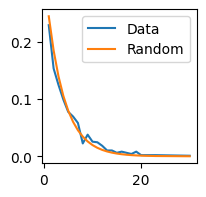

feature_Has specialized courtship behavior 0.9870717517776342 0.9501246882793017
{1: 6, 2: 3, 3: 3, 4: 8, 5: 11, 6: 4, 7: 10, 8: 5, 9: 8, 10: 4, 11: 6, 12: 6, 13: 7, 14: 8, 15: 10, 16: 7, 17: 8, 18: 6, 19: 10, 20: 6, 21: 13, 22: 10, 23: 9, 24: 6, 25: 9, 26: 5, 27: 11, 28: 16, 29: 6, 30: 11, 31: 13, 32: 7, 33: 10, 34: 8, 35: 5, 36: 9, 37: 5, 38: 4, 42: 2}
Chi-Square Statistic: 60.35407600849725, p-value: 0.011964997646557106


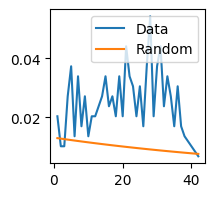

feature_Exhibits territorial marking 0.7965416936005171 0.6608478802992519
{1: 244, 2: 185, 3: 149, 4: 119, 5: 88, 6: 64, 7: 59, 8: 48, 9: 39, 10: 22, 11: 24, 12: 18, 13: 12, 14: 4, 15: 9, 16: 2, 17: 2, 18: 7, 19: 5, 20: 2, 21: 1, 25: 1}
Chi-Square Statistic: 19.987810810353352, p-value: 0.5220334496526187


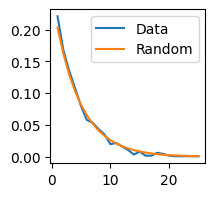

feature_Is associated with mythology or folklore 0.9924046541693601 0.9326683291770573
{1: 8, 2: 5, 3: 2, 4: 2, 5: 6, 6: 8, 7: 3, 8: 2, 9: 6, 10: 5, 11: 4, 12: 1, 13: 3, 14: 5, 15: 5, 16: 9, 17: 5, 18: 2, 19: 6, 20: 3, 21: 12, 22: 4, 23: 7, 24: 4, 25: 13, 26: 5, 27: 16, 28: 11, 29: 11, 30: 13, 31: 13, 32: 6, 33: 9, 34: 7, 35: 7, 36: 9, 37: 5, 38: 8, 39: 2, 40: 2, 42: 3, 44: 1, 45: 1, 46: 1, 47: 1, 56: 1}
Chi-Square Statistic: 123.2422202058968, p-value: 3.3217697468552828e-09


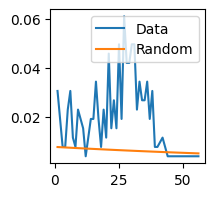

feature_Exhibits altruistic behavior 0.8440530058177117 0.7506234413965087
{1: 158, 2: 124, 3: 98, 4: 85, 5: 78, 6: 68, 7: 51, 8: 51, 9: 31, 10: 37, 11: 28, 12: 20, 13: 18, 14: 14, 15: 8, 16: 12, 17: 9, 18: 4, 19: 8, 20: 1, 21: 1, 22: 2, 23: 1, 24: 2, 25: 1, 26: 1, 28: 1, 29: 1, 40: 1}
Chi-Square Statistic: 26.021560434842822, p-value: 0.571859388012296


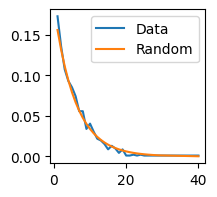

feature_Is a keystone species in its ecosystem 0.19634776987718164 0.14214463840399003
{1: 538, 2: 195, 3: 57, 4: 16, 5: 9, 7: 1}
Chi-Square Statistic: 210.2340182574557, p-value: 1.8336595330048847e-43


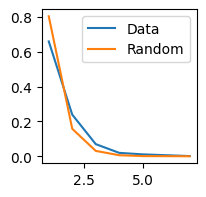

feature_Uses burrows or dens for shelter 0.3212669683257919 0.33665835411471323
{1: 595, 2: 308, 3: 125, 4: 52, 5: 21, 6: 10, 7: 3, 8: 1}
Chi-Square Statistic: 158.49339423214997, p-value: 6.65603194109986e-31


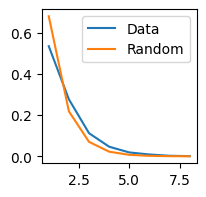

feature_Can regenerate body parts 0.42210730446024564 0.44389027431421446
{1: 723, 2: 303, 3: 158, 4: 78, 5: 34, 6: 21, 7: 15, 8: 5, 9: 5, 11: 1}
Chi-Square Statistic: 88.27316846398168, p-value: 3.613130711351303e-15


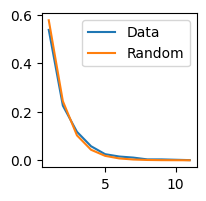

feature_Is raised in captivity or farms 0.6194246929541047 0.4912718204488778
{1: 533, 2: 288, 3: 201, 4: 119, 5: 98, 6: 46, 7: 37, 8: 21, 9: 16, 10: 11, 11: 6, 12: 5, 13: 2, 15: 2, 16: 1}
Chi-Square Statistic: 22.775403579585372, p-value: 0.06402388793033985


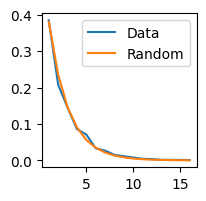

feature_Has unique reproductive strategies (e.g., asexual reproduction) 0.2519392372333549 0.32418952618453867
{1: 523, 2: 209, 3: 92, 4: 38, 5: 24, 6: 2, 7: 2, 8: 3, 9: 1, 11: 1}
Chi-Square Statistic: 2099.7091765915798, p-value: 0.0


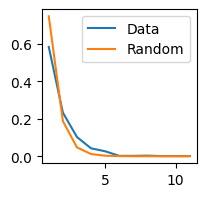

feature_Hibernates during winter 0.013736263736263736 0.022443890274314215
{1: 85}
Chi-Square Statistic: 0.0, p-value: nan


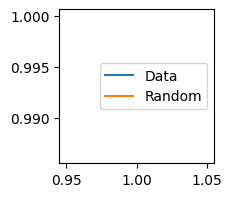

feature_Has a role in biological pest control 0.9667097608274079 0.9152119700748129
{1: 26, 2: 17, 3: 14, 4: 14, 5: 20, 6: 13, 7: 15, 8: 8, 9: 15, 10: 12, 11: 10, 12: 10, 13: 14, 14: 11, 15: 16, 16: 18, 17: 9, 18: 7, 19: 8, 20: 14, 21: 11, 22: 9, 23: 13, 24: 6, 25: 7, 26: 9, 27: 7, 28: 10, 29: 7, 30: 6, 31: 7, 32: 7, 33: 6, 34: 2, 35: 3, 36: 3, 37: 2, 38: 2, 40: 1, 42: 2, 43: 1, 47: 1}
Chi-Square Statistic: 44.78767841136621, p-value: 0.3158952422160319


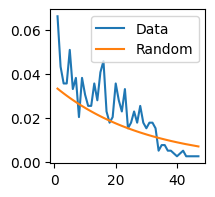

feature_Has distinct seasonal breeding cycles 0.3387201034259858 0.314214463840399
{1: 689, 2: 260, 3: 118, 4: 55, 5: 29, 6: 10, 7: 10, 8: 2, 10: 1, 12: 1}
Chi-Square Statistic: 368.41586317876124, p-value: 7.42560354641763e-74


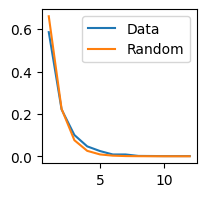

feature_Forms a symbiotic relationship with plants (e.g., pollination) 0.034744667097608276 0.05236907730673317
{1: 165, 2: 17, 3: 4, 4: 1}
Chi-Square Statistic: 215.42171141508715, p-value: 1.9604541476827397e-46


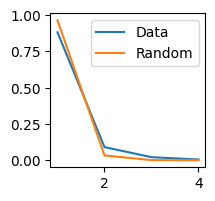

feature_Uses specific vocalizations to communicate 0.7569489334195216 0.6209476309226932
{1: 224, 2: 166, 3: 118, 4: 102, 5: 85, 6: 64, 7: 60, 8: 46, 9: 32, 10: 31, 11: 25, 12: 18, 13: 21, 14: 13, 16: 3, 17: 4, 19: 1, 20: 1, 22: 1, 23: 1, 25: 1}
Chi-Square Statistic: 58.61428036503437, p-value: 1.1643532428837081e-05


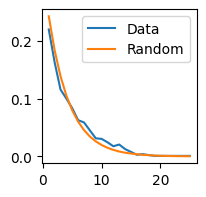

feature_Is a flagship species (conservation symbol) 0.5415319974143503 0.43640897755610975
{1: 534, 2: 277, 3: 155, 4: 87, 5: 74, 6: 61, 7: 17, 8: 17, 9: 15, 10: 13, 11: 8, 12: 1, 13: 1, 14: 2, 17: 2, 19: 1}
Chi-Square Statistic: 431.83708045002516, p-value: 1.3859012165696998e-82


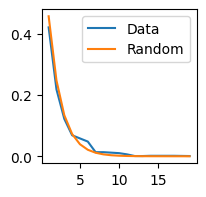

feature_Can be trained or tamed by humans 0.4638009049773756 0.2793017456359102
{1: 502, 2: 248, 3: 138, 4: 102, 5: 63, 6: 47, 7: 19, 8: 14, 9: 10, 10: 5, 11: 4, 12: 2}
Chi-Square Statistic: 413.76919561910455, p-value: 7.287594450723699e-82


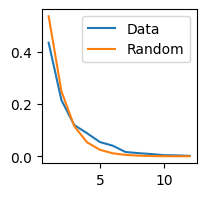

feature_Displays warning coloration 0.2537168713639302 0.32418952618453867
{1: 666, 2: 206, 3: 69, 4: 30, 5: 14, 6: 7, 7: 5, 8: 1, 10: 1}
Chi-Square Statistic: 572.7620510079439, p-value: 1.6731687094997541e-118


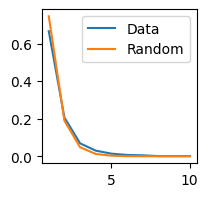

feature_Has flippers 0.08791208791208792 0.07481296758104738
{1: 164, 2: 59, 3: 45, 4: 16, 5: 4, 6: 6, 7: 1}
Chi-Square Statistic: 36852.90447444202, p-value: 0.0


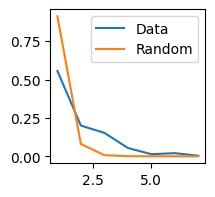

feature_Has compound eyes 0.2949256625727214 0.3516209476309227
{1: 707, 2: 236, 3: 88, 4: 32, 5: 24, 6: 6, 7: 5, 8: 1, 10: 2, 11: 1, 12: 2}
Chi-Square Statistic: 4182.180292403411, p-value: 0.0


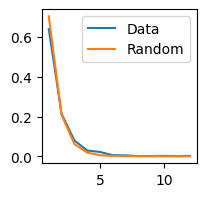

feature_Has a segmented body 0.1195862960568843 0.24688279301745636
{1: 366, 2: 117, 3: 28, 4: 9, 5: 1, 6: 1, 9: 1}
Chi-Square Statistic: 52260.75692217927, p-value: 0.0


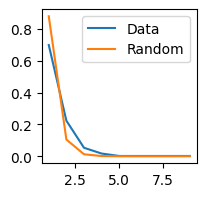

In [18]:
remove_columns_vf.extend(make_persistance_plots_conditional(data_vf, vf_featuredf, vf_featurecols))

In [ ]:
make_persistance_plots_hazard(data_vf, vf_featuredf, vf_featurecols)

In [ ]:
remove_columns_autbrick.extend(make_persistance_plots_conditional(data_autbrick, autbrick_featuredf, autbrick_featurecols))

In [ ]:
make_persistance_plots_hazard(data_autbrick, autbrick_featuredf, autbrick_featurecols)

In [ ]:
remove_columns_autpaperclip.extend(make_persistance_plots_conditional(data_autpaperclip, autpaperclip_featuredf, autpaperclip_featurecols))

In [ ]:
make_persistance_plots_hazard(data_autpaperclip, autpaperclip_featuredf, autpaperclip_featurecols)

# Remove features

In [19]:
vf_featuredf = vf_featuredf.drop(columns = remove_columns_vf)
vf_featurecols = [item for item in vf_featurecols if item not in remove_columns_vf]
autbrick_featuredf = autbrick_featuredf.drop(columns = remove_columns_autbrick)
autbrick_featurecols = [item for item in autbrick_featurecols if item not in remove_columns_autbrick]
autpaperclip_featuredf = autpaperclip_featuredf.drop(columns = remove_columns_autpaperclip)
autpaperclip_featurecols = [item for item in autpaperclip_featurecols if item not in remove_columns_autpaperclip]

In [20]:
print(len(vf_featurecols), len(autbrick_featurecols), len(autpaperclip_featurecols))

73 111 97


In [21]:
def get_num_features_same(df, featurecols):
    df['num_features_same'] = None
    df = df.groupby('pid', group_keys=False).apply(calculate_num_features_same, featurecols = featurecols)
    return df

def calculate_num_features_same(group, featurecols):
    group = group.reset_index(drop=True)
    num_features_same = [np.nan]  # Initialize with nan for the first row
    
    for i in range(1, len(group)):
        row1 = group.loc[i - 1, featurecols]
        row2 = group.loc[i, featurecols]
        
        # Check for NaN values
        if row1.isna().any() or row2.isna().any():
            num_features_same.append(np.nan)
        else:
            consecutive_1s = (row1 == 1) & (row2 == 1)
            num_features_same.append(consecutive_1s.sum())
    
    group['num_features_same'] = num_features_same
    return group

data_vf = get_num_features_same(data_vf, vf_featurecols)
data_autbrick = get_num_features_same(data_autbrick, autbrick_featurecols)
data_autpaperclip = get_num_features_same(data_autpaperclip, autpaperclip_featurecols)

/tmp/ipykernel_3135473/2698670700.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['num_features_same_2back'] = None
/tmp/ipykernel_3135473/2698670700.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('pid', group_keys=False).apply(calculate_num_features_same, featurecols = featurecols)
/tmp/ipykernel_3135473/2698670700.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, wh

In [24]:
def get_num_features_same(df, featurecols):
    df['num_features_same_2back'] = np.nan  # Initialize the column with NaN
    df = df.groupby('pid', group_keys=False).apply(calculate_num_features_same, featurecols=featurecols)
    return df

def calculate_num_features_same(group, featurecols):
    group = group.reset_index(drop=True)
    
    num_features_same = np.full(len(group), np.nan)  # Initialize with NaN
    
    for i in range(2, len(group)):
        row1 = group.loc[i - 2, featurecols]
        row2 = group.loc[i, featurecols]

        # Check for NaN values
        if row1.isna().any() or row2.isna().any():
            num_features_same[i] = np.nan
        else:
            consecutive_1s = (row1 == 1) & (row2 == 1)
            num_features_same[i] = consecutive_1s.sum()
    
    group['num_features_same_2back'] = num_features_same  # Assign correctly
    return group

# Apply the function to your datasets
data_vf = get_num_features_same(data_vf, vf_featurecols)
data_autbrick = get_num_features_same(data_autbrick, autbrick_featurecols)
data_autpaperclip = get_num_features_same(data_autpaperclip, autpaperclip_featurecols)

/tmp/ipykernel_3135473/2595230365.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('pid', group_keys=False).apply(calculate_num_features_same, featurecols=featurecols)
/tmp/ipykernel_3135473/2595230365.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('pid', group_keys=False).apply(calculate_num_features_same, featurecols=featurecols)
/tmp/ipykernel_3135473/2595230365.py

In [26]:
def get_num_features_same(df, featurecols):
    df['num_features_same_3back'] = np.nan  # Initialize the column with NaN
    df = df.groupby('pid', group_keys=False).apply(calculate_num_features_same, featurecols=featurecols)
    return df

def calculate_num_features_same(group, featurecols):
    group = group.reset_index(drop=True)
    
    num_features_same = np.full(len(group), np.nan)  # Initialize with NaN
    
    for i in range(3, len(group)):
        row1 = group.loc[i - 3, featurecols]
        row2 = group.loc[i, featurecols]

        # Check for NaN values
        if row1.isna().any() or row2.isna().any():
            num_features_same[i] = np.nan
        else:
            consecutive_1s = (row1 == 1) & (row2 == 1)
            num_features_same[i] = consecutive_1s.sum()
    
    group['num_features_same_3back'] = num_features_same  # Assign correctly
    return group

# Apply the function to your datasets
data_vf = get_num_features_same(data_vf, vf_featurecols)
data_autbrick = get_num_features_same(data_autbrick, autbrick_featurecols)
data_autpaperclip = get_num_features_same(data_autpaperclip, autpaperclip_featurecols)

/tmp/ipykernel_3135473/2499857689.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('pid', group_keys=False).apply(calculate_num_features_same, featurecols=featurecols)
/tmp/ipykernel_3135473/2499857689.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('pid', group_keys=False).apply(calculate_num_features_same, featurecols=featurecols)
/tmp/ipykernel_3135473/2499857689.py

In [30]:
def get_num_features_same(df, featurecols):
    df['num_features_same_4back'] = np.nan  # Initialize the column with NaN
    df = df.groupby('pid', group_keys=False).apply(calculate_num_features_same, featurecols=featurecols)
    return df

def calculate_num_features_same(group, featurecols):
    group = group.reset_index(drop=True)
    
    num_features_same = np.full(len(group), np.nan)  # Initialize with NaN
    
    for i in range(4, len(group)):
        row1 = group.loc[i - 4, featurecols]
        row2 = group.loc[i, featurecols]

        # Check for NaN values
        if row1.isna().any() or row2.isna().any():
            num_features_same[i] = np.nan
        else:
            consecutive_1s = (row1 == 1) & (row2 == 1)
            num_features_same[i] = consecutive_1s.sum()
    
    group['num_features_same_4back'] = num_features_same  # Assign correctly
    return group

# Apply the function to your datasets
data_vf = get_num_features_same(data_vf, vf_featurecols)
data_autbrick = get_num_features_same(data_autbrick, autbrick_featurecols)
data_autpaperclip = get_num_features_same(data_autpaperclip, autpaperclip_featurecols)

/tmp/ipykernel_3135473/2330576218.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('pid', group_keys=False).apply(calculate_num_features_same, featurecols=featurecols)
/tmp/ipykernel_3135473/2330576218.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('pid', group_keys=False).apply(calculate_num_features_same, featurecols=featurecols)
/tmp/ipykernel_3135473/2330576218.py

In [31]:
def get_num_features_same(df, featurecols):
    df['num_features_same_5back'] = np.nan  # Initialize the column with NaN
    df = df.groupby('pid', group_keys=False).apply(calculate_num_features_same, featurecols=featurecols)
    return df

def calculate_num_features_same(group, featurecols):
    group = group.reset_index(drop=True)
    
    num_features_same = np.full(len(group), np.nan)  # Initialize with NaN
    
    for i in range(5, len(group)):
        row1 = group.loc[i - 5, featurecols]
        row2 = group.loc[i, featurecols]

        # Check for NaN values
        if row1.isna().any() or row2.isna().any():
            num_features_same[i] = np.nan
        else:
            consecutive_1s = (row1 == 1) & (row2 == 1)
            num_features_same[i] = consecutive_1s.sum()
    
    group['num_features_same_5back'] = num_features_same  # Assign correctly
    return group

# Apply the function to your datasets
data_vf = get_num_features_same(data_vf, vf_featurecols)
data_autbrick = get_num_features_same(data_autbrick, autbrick_featurecols)
data_autpaperclip = get_num_features_same(data_autpaperclip, autpaperclip_featurecols)

/tmp/ipykernel_3135473/254639300.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('pid', group_keys=False).apply(calculate_num_features_same, featurecols=featurecols)
/tmp/ipykernel_3135473/254639300.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('pid', group_keys=False).apply(calculate_num_features_same, featurecols=featurecols)
/tmp/ipykernel_3135473/254639300.py:3:

In [36]:
def get_num_features_same(df, featurecols):
    df['num_features_same_6back'] = np.nan  # Initialize the column with NaN
    df = df.groupby('pid', group_keys=False).apply(calculate_num_features_same, featurecols=featurecols)
    return df

def calculate_num_features_same(group, featurecols):
    group = group.reset_index(drop=True)
    
    num_features_same = np.full(len(group), np.nan)  # Initialize with NaN
    
    for i in range(6, len(group)):
        row1 = group.loc[i - 6, featurecols]
        row2 = group.loc[i, featurecols]

        # Check for NaN values
        if row1.isna().any() or row2.isna().any():
            num_features_same[i] = np.nan
        else:
            consecutive_1s = (row1 == 1) & (row2 == 1)
            num_features_same[i] = consecutive_1s.sum()
    
    group['num_features_same_6back'] = num_features_same  # Assign correctly
    return group

# Apply the function to your datasets
data_vf = get_num_features_same(data_vf, vf_featurecols)
data_autbrick = get_num_features_same(data_autbrick, autbrick_featurecols)
data_autpaperclip = get_num_features_same(data_autpaperclip, autpaperclip_featurecols)

/tmp/ipykernel_3135473/2185834437.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('pid', group_keys=False).apply(calculate_num_features_same, featurecols=featurecols)
/tmp/ipykernel_3135473/2185834437.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('pid', group_keys=False).apply(calculate_num_features_same, featurecols=featurecols)
/tmp/ipykernel_3135473/2185834437.py

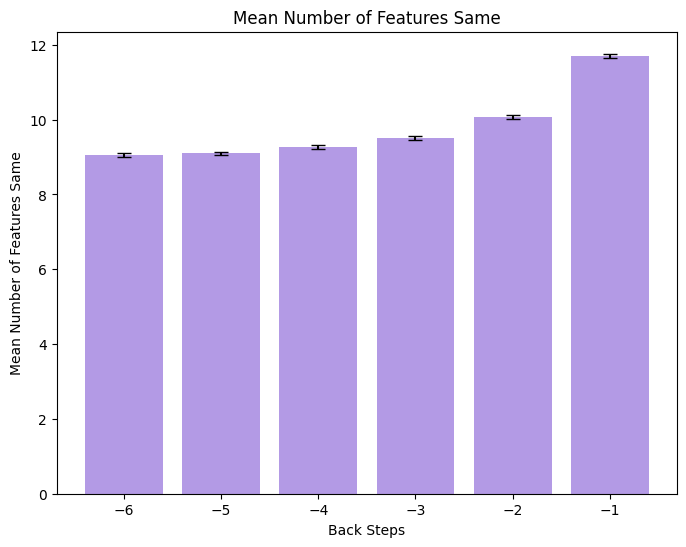

In [67]:
# Calculate means and standard errors
means = [
    np.mean(data_vf["num_features_same_6back"]),
    np.mean(data_vf["num_features_same_5back"]),
    np.mean(data_vf["num_features_same_4back"]),
    np.mean(data_vf["num_features_same_3back"]),
    np.mean(data_vf["num_features_same_2back"]),
    np.mean(data_vf["num_features_same"])
]

std_errors = [
    np.std(data_vf["num_features_same_6back"], ddof=1) / np.sqrt(len(data_vf["num_features_same_6back"].dropna())),
    np.std(data_vf["num_features_same_5back"], ddof=1) / np.sqrt(len(data_vf["num_features_same_5back"].dropna())),
    np.std(data_vf["num_features_same_4back"], ddof=1) / np.sqrt(len(data_vf["num_features_same_4back"].dropna())),
    np.std(data_vf["num_features_same_3back"], ddof=1) / np.sqrt(len(data_vf["num_features_same_3back"].dropna())),
    np.std(data_vf["num_features_same_2back"], ddof=1) / np.sqrt(len(data_vf["num_features_same_2back"].dropna())),
    np.std(data_vf["num_features_same"], ddof=1) / np.sqrt(len(data_vf["num_features_same"].dropna()))
]

x_labels = [-6, -5, -4, -3, -2, -1]

# Plot bar chart with error bars
plt.figure(figsize=(8, 6))
plt.bar(x_labels, means, yerr=std_errors, capsize=5, alpha=0.7, color='mediumpurple')
plt.xlabel("Back Steps")
plt.ylabel("Mean Number of Features Same")
plt.title("Mean Number of Features Same")
plt.show()

In [79]:
def get_num_features_same(df, featurecols):
    df['RT_diff'] = np.nan  # Initialize the column with NaN
    df = df.groupby('pid', group_keys=False).apply(calculate_num_features_same, featurecols=featurecols)
    return df

def calculate_num_features_same(group, featurecols):
    group = group.reset_index(drop=True)
    
    num_features_same = np.full(len(group), np.nan)  # Initialize with NaN
    
    for i in range(1, len(group)):
        row1 = group.loc[i - 1, ["RT"]]
        row2 = group.loc[i, ["RT"]]

        # Check for NaN values
        if row1.isna().any() or row2.isna().any():
            num_features_same[i] = np.nan
        else:
            RTdiff = row2["RT"] - row1["RT"]
            num_features_same[i] = RTdiff
    
    group['RT_diff'] = num_features_same  # Assign correctly
    return group

# Apply the function to your datasets
data_vf = get_num_features_same(data_vf, vf_featurecols)
data_autbrick = get_num_features_same(data_autbrick, autbrick_featurecols)
data_autpaperclip = get_num_features_same(data_autpaperclip, autpaperclip_featurecols)

/tmp/ipykernel_3135473/3482891411.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('pid', group_keys=False).apply(calculate_num_features_same, featurecols=featurecols)
/tmp/ipykernel_3135473/3482891411.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('pid', group_keys=False).apply(calculate_num_features_same, featurecols=featurecols)
/tmp/ipykernel_3135473/3482891411.py

In [80]:
def get_num_features_same(df, featurecols):
    df['RT_diff_2back'] = np.nan  # Initialize the column with NaN
    df = df.groupby('pid', group_keys=False).apply(calculate_num_features_same, featurecols=featurecols)
    return df

def calculate_num_features_same(group, featurecols):
    group = group.reset_index(drop=True)
    
    num_features_same = np.full(len(group), np.nan)  # Initialize with NaN
    
    for i in range(2, len(group)):
        row1 = group.loc[i - 2, ["RT"]]
        row2 = group.loc[i, ["RT"]]

        # Check for NaN values
        if row1.isna().any() or row2.isna().any():
            num_features_same[i] = np.nan
        else:
            RTdiff = row2["RT"] - row1["RT"]
            num_features_same[i] = RTdiff
    
    group['RT_diff_2back'] = num_features_same  # Assign correctly
    return group

# Apply the function to your datasets
data_vf = get_num_features_same(data_vf, vf_featurecols)
data_autbrick = get_num_features_same(data_autbrick, autbrick_featurecols)
data_autpaperclip = get_num_features_same(data_autpaperclip, autpaperclip_featurecols)

/tmp/ipykernel_3135473/262811134.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('pid', group_keys=False).apply(calculate_num_features_same, featurecols=featurecols)
/tmp/ipykernel_3135473/262811134.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('pid', group_keys=False).apply(calculate_num_features_same, featurecols=featurecols)
/tmp/ipykernel_3135473/262811134.py:3:

In [81]:
def get_num_features_same(df, featurecols):
    df['RT_diff_3back'] = np.nan  # Initialize the column with NaN
    df = df.groupby('pid', group_keys=False).apply(calculate_num_features_same, featurecols=featurecols)
    return df

def calculate_num_features_same(group, featurecols):
    group = group.reset_index(drop=True)
    
    num_features_same = np.full(len(group), np.nan)  # Initialize with NaN
    
    for i in range(3, len(group)):
        row1 = group.loc[i - 3, ["RT"]]
        row2 = group.loc[i, ["RT"]]

        # Check for NaN values
        if row1.isna().any() or row2.isna().any():
            num_features_same[i] = np.nan
        else:
            RTdiff = row2["RT"] - row1["RT"]
            num_features_same[i] = RTdiff
    
    group['RT_diff_3back'] = num_features_same  # Assign correctly
    return group

# Apply the function to your datasets
data_vf = get_num_features_same(data_vf, vf_featurecols)
data_autbrick = get_num_features_same(data_autbrick, autbrick_featurecols)
data_autpaperclip = get_num_features_same(data_autpaperclip, autpaperclip_featurecols)

/tmp/ipykernel_3135473/3417072070.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('pid', group_keys=False).apply(calculate_num_features_same, featurecols=featurecols)
/tmp/ipykernel_3135473/3417072070.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('pid', group_keys=False).apply(calculate_num_features_same, featurecols=featurecols)
/tmp/ipykernel_3135473/3417072070.py

In [82]:
def get_num_features_same(df, featurecols):
    df['RT_diff_4back'] = np.nan  # Initialize the column with NaN
    df = df.groupby('pid', group_keys=False).apply(calculate_num_features_same, featurecols=featurecols)
    return df

def calculate_num_features_same(group, featurecols):
    group = group.reset_index(drop=True)
    
    num_features_same = np.full(len(group), np.nan)  # Initialize with NaN
    
    for i in range(4, len(group)):
        row1 = group.loc[i - 4, ["RT"]]
        row2 = group.loc[i, ["RT"]]

        # Check for NaN values
        if row1.isna().any() or row2.isna().any():
            num_features_same[i] = np.nan
        else:
            RTdiff = row2["RT"] - row1["RT"]
            num_features_same[i] = RTdiff
    
    group['RT_diff_4back'] = num_features_same  # Assign correctly
    return group

# Apply the function to your datasets
data_vf = get_num_features_same(data_vf, vf_featurecols)
data_autbrick = get_num_features_same(data_autbrick, autbrick_featurecols)
data_autpaperclip = get_num_features_same(data_autpaperclip, autpaperclip_featurecols)

/tmp/ipykernel_3135473/1118184044.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('pid', group_keys=False).apply(calculate_num_features_same, featurecols=featurecols)
/tmp/ipykernel_3135473/1118184044.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('pid', group_keys=False).apply(calculate_num_features_same, featurecols=featurecols)
/tmp/ipykernel_3135473/1118184044.py

In [83]:
def get_num_features_same(df, featurecols):
    df['RT_diff_5back'] = np.nan  # Initialize the column with NaN
    df = df.groupby('pid', group_keys=False).apply(calculate_num_features_same, featurecols=featurecols)
    return df

def calculate_num_features_same(group, featurecols):
    group = group.reset_index(drop=True)
    
    num_features_same = np.full(len(group), np.nan)  # Initialize with NaN
    
    for i in range(5, len(group)):
        row1 = group.loc[i - 5, ["RT"]]
        row2 = group.loc[i, ["RT"]]

        # Check for NaN values
        if row1.isna().any() or row2.isna().any():
            num_features_same[i] = np.nan
        else:
            RTdiff = row2["RT"] - row1["RT"]
            num_features_same[i] = RTdiff
    
    group['RT_diff_5back'] = num_features_same  # Assign correctly
    return group

# Apply the function to your datasets
data_vf = get_num_features_same(data_vf, vf_featurecols)
data_autbrick = get_num_features_same(data_autbrick, autbrick_featurecols)
data_autpaperclip = get_num_features_same(data_autpaperclip, autpaperclip_featurecols)

/tmp/ipykernel_3135473/3921987345.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('pid', group_keys=False).apply(calculate_num_features_same, featurecols=featurecols)
/tmp/ipykernel_3135473/3921987345.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('pid', group_keys=False).apply(calculate_num_features_same, featurecols=featurecols)
/tmp/ipykernel_3135473/3921987345.py

In [84]:
def get_num_features_same(df, featurecols):
    df['RT_diff_6back'] = np.nan  # Initialize the column with NaN
    df = df.groupby('pid', group_keys=False).apply(calculate_num_features_same, featurecols=featurecols)
    return df

def calculate_num_features_same(group, featurecols):
    group = group.reset_index(drop=True)
    
    num_features_same = np.full(len(group), np.nan)  # Initialize with NaN
    
    for i in range(6, len(group)):
        row1 = group.loc[i - 6, ["RT"]]
        row2 = group.loc[i, ["RT"]]

        # Check for NaN values
        if row1.isna().any() or row2.isna().any():
            num_features_same[i] = np.nan
        else:
            RTdiff = row2["RT"] - row1["RT"]
            num_features_same[i] = RTdiff
    
    group['RT_diff_6back'] = num_features_same  # Assign correctly
    return group

# Apply the function to your datasets
data_vf = get_num_features_same(data_vf, vf_featurecols)
data_autbrick = get_num_features_same(data_autbrick, autbrick_featurecols)
data_autpaperclip = get_num_features_same(data_autpaperclip, autpaperclip_featurecols)

/tmp/ipykernel_3135473/983482392.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('pid', group_keys=False).apply(calculate_num_features_same, featurecols=featurecols)
/tmp/ipykernel_3135473/983482392.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('pid', group_keys=False).apply(calculate_num_features_same, featurecols=featurecols)
/tmp/ipykernel_3135473/983482392.py:3:

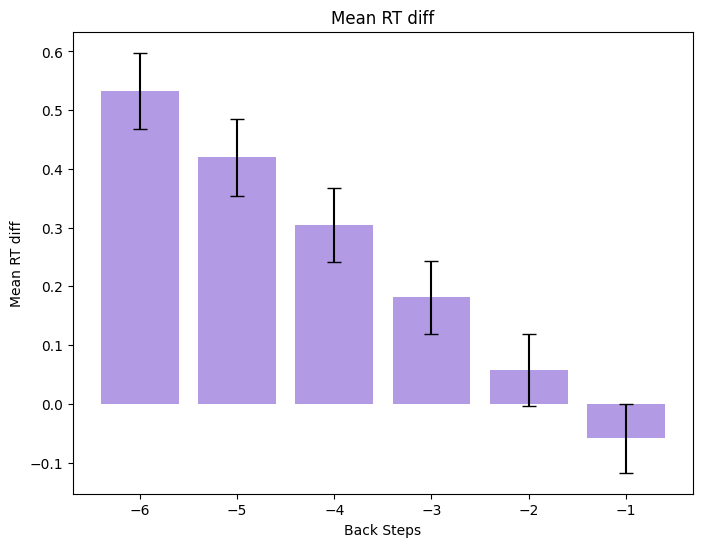

In [85]:
# Calculate means and standard errors
means = [
    np.mean(data_vf["RT_diff_6back"]),
    np.mean(data_vf["RT_diff_5back"]),
    np.mean(data_vf["RT_diff_4back"]),
    np.mean(data_vf["RT_diff_3back"]),
    np.mean(data_vf["RT_diff_2back"]),
    np.mean(data_vf["RT_diff"])
]

std_errors = [
    np.std(data_vf["RT_diff_6back"], ddof=1) / np.sqrt(len(data_vf["RT_diff_6back"].dropna())),
    np.std(data_vf["RT_diff_5back"], ddof=1) / np.sqrt(len(data_vf["RT_diff_5back"].dropna())),
    np.std(data_vf["RT_diff_4back"], ddof=1) / np.sqrt(len(data_vf["RT_diff_4back"].dropna())),
    np.std(data_vf["RT_diff_3back"], ddof=1) / np.sqrt(len(data_vf["RT_diff_3back"].dropna())),
    np.std(data_vf["RT_diff_2back"], ddof=1) / np.sqrt(len(data_vf["RT_diff_2back"].dropna())),
    np.std(data_vf["RT_diff"], ddof=1) / np.sqrt(len(data_vf["RT_diff"].dropna()))
]

x_labels = [-6, -5, -4, -3, -2, -1]

# Plot bar chart with error bars
plt.figure(figsize=(8, 6))
plt.bar(x_labels, means, yerr=std_errors, capsize=5, alpha=0.7, color='mediumpurple')
plt.xlabel("Back Steps")
plt.ylabel("Mean RT diff")
plt.title("Mean RT diff")
plt.show()

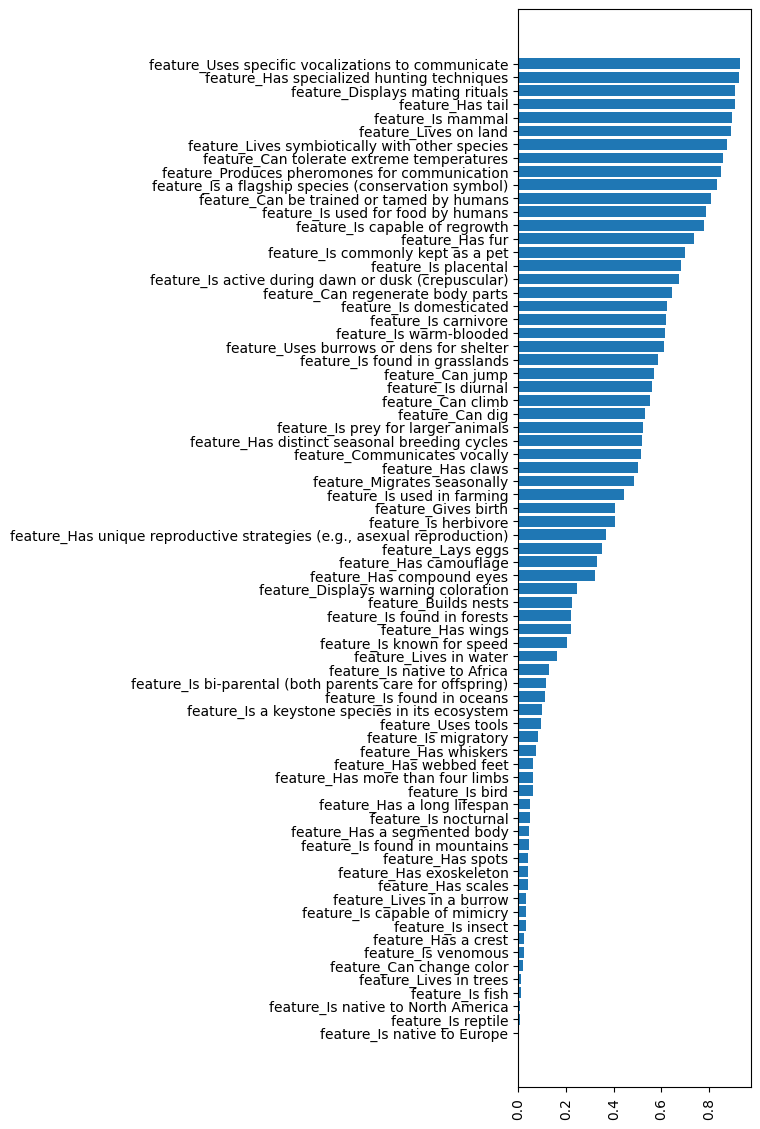

In [ ]:
def has_two_chunks(lst):
    count = 0  # Count of contiguous chunks of ones with length > 1
    i = 0
    while i < len(lst):
        if lst[i] == 1:
            start = i
            while i < len(lst) and lst[i] == 1:
                i += 1
            if i - start > 1:
                count += 1
                if count >= 2:
                    return 1
        else:
            i += 1
    return 0

# Apply function to each feature_* column, grouped by 'pid'
returned_to_same_feature = {
    col: data_vf.groupby("pid")[col].apply(has_two_chunks) for col in vf_featurecols
}

# Convert results to DataFrame
returned_to_same_feature_df = pd.DataFrame(returned_to_same_feature)
returned = (np.sum(returned_to_same_feature_df, axis=0)/len(data_vf["pid"].unique())).to_dict()
returned = dict(sorted(returned.items(), key=lambda item: item[1]))
plt.figure(figsize=(3,14))
plt.barh(list(returned.keys()), list(returned.values()))
plt.xticks(rotation=90);

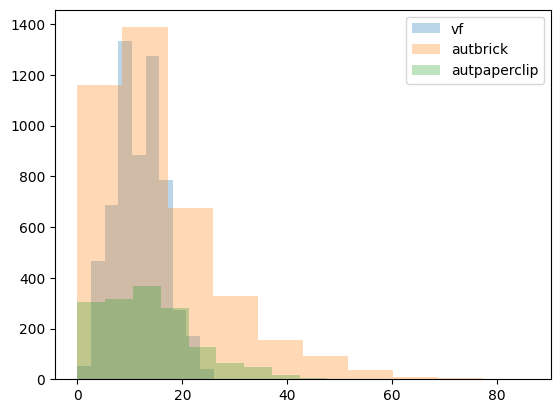

In [97]:
plt.hist(data_vf["num_features_same"], alpha=0.3, label="vf");
plt.hist(data_autbrick["num_features_same"], alpha=0.3, label="autbrick");
plt.hist(data_autpaperclip["num_features_same"], alpha=0.3, label="autpaperclip");
plt.legend();

In [27]:
data_vf = data_vf[(data_vf["order"] > 0) & (data_vf["order"] < 20)]
data_autbrick = data_autbrick[(data_autbrick["order"] > 0) & (data_autbrick["order"] < 20)]
data_autpaperclip = data_autpaperclip[(data_autpaperclip["order"] > 0) & (data_autpaperclip["order"] < 20)]

In [28]:
data_humans = pd.read_csv("../csvs/data_humans.csv")

In [29]:
data_vf = pd.merge(data_vf, data_humans[data_humans["task"] == 1].drop("Unnamed: 0", axis=1), on=['pid', 'task', 'starttime', 'endtime', 'original_response_Dutch',
       'original_response', 'original_response_cleaned', 'response', 'invalid', 'response_len', 'response_num_words', 'previous_original_response', 'previous_response', 'order', 'RT'], how='left')
data_vf = data_vf[~data_vf["response"].isin(vf_to_remove)]

data_autbrick = pd.merge(data_autbrick, data_humans[data_humans["task"] == 2].drop("Unnamed: 0", axis=1), on=['pid', 'task', 'starttime', 'endtime', 'original_response_Dutch',
       'original_response', 'original_response_cleaned', 'response', 'invalid', 'response_len', 'response_num_words', 'previous_original_response', 'previous_response', 'order', 'RT'], how='left')
data_autpaperclip = pd.merge(data_autpaperclip, data_humans[data_humans["task"] == 3].drop("Unnamed: 0", axis=1), on=['pid', 'task', 'starttime', 'endtime', 'original_response_Dutch',
       'original_response', 'original_response_cleaned', 'response', 'invalid', 'response_len', 'response_num_words', 'previous_original_response', 'previous_response', 'order', 'RT'], how='left')

In [ ]:
plt.figure()
valid_indices = ~np.isnan(data_vf["SS"]) & ~np.isnan(data_vf["num_features_same"])
filtered_SS = data_vf["SS"][valid_indices]
filtered_num_features_same = data_vf["num_features_same"][valid_indices]
plt.scatter(filtered_SS, filtered_num_features_same, alpha=0.3)
print(np.corrcoef(filtered_SS, filtered_num_features_same)[0,1])
plt.xlabel("SS")
plt.ylabel("Number of features same");

plt.figure()
plt.scatter(data_autbrick["SS"], data_autbrick["num_features_same"])
plt.xlabel("SS")
plt.ylabel("Number of features same");

plt.figure()
plt.scatter(data_autpaperclip["SS"], data_autpaperclip["num_features_same"])
plt.xlabel("SS")
plt.ylabel("Number of features same");

In [ ]:
# least similar
print(data_vf[["response", "previous_response", "num_features_same", "SS", "jump"]][data_vf["num_features_same"] < 10]["SS"].mean())
data_vf[["response", "previous_response", "num_features_same", "SS", "jump"]][data_vf["num_features_same"] < 10].drop_duplicates().head(50)

In [ ]:
# most similar
print(data_vf[["response", "previous_response", "num_features_same", "SS", "jump"]][data_vf["num_features_same"] > 15]["SS"].mean())
data_vf[["response", "previous_response", "num_features_same", "SS", "jump"]][data_vf["num_features_same"] > 15].drop_duplicates().sort_values(by=["num_features_same"], ascending=False).head(50)

In [ ]:
# plt.scatter(data_vf[["pid", "jump_profile"]].groupby("pid").max().reset_index()["jump_profile"].values, data_vf[["pid", "num_features_same"]].groupby("pid").mean()["num_features_same"].values)
plt.figure()
plt.scatter(np.arange(219), pd.merge(data_vf[["pid", "num_features_same"]].groupby("pid").mean().reset_index(), data_vf[["pid", "jump_profile"]].groupby("pid").max().reset_index(), on=["pid"]).sort_values("jump_profile")["num_features_same"])
plt.xlabel("Max jump profile")
plt.ylabel("Mean features same");

plt.figure()
t = pd.merge(data_autbrick[["pid", "num_features_same"]].groupby("pid").mean().reset_index(), data_autbrick[["pid", "jump_profile"]].groupby("pid").max().reset_index(), on=["pid"]).sort_values("jump_profile")["num_features_same"]
plt.scatter(np.arange(len(t)), t)
plt.xlabel("Max jump profile")
plt.ylabel("Mean features same");

plt.figure()
t = pd.merge(data_autpaperclip[["pid", "num_features_same"]].groupby("pid").mean().reset_index(), data_autpaperclip[["pid", "jump_profile"]].groupby("pid").max().reset_index(), on=["pid"]).sort_values("jump_profile")["num_features_same"]
plt.scatter(np.arange(len(t)), t)
plt.xlabel("Max jump profile")
plt.ylabel("Mean features same");

In [34]:
def plot_binary_features_heatmap(df, featurecols):
    pids = df["pid"].unique()
    cnt = 1
    for pid in pids:
        responses = df[df["pid"] == pid]["response"].values
        pid_data = df[df["pid"] == pid][featurecols].reset_index(drop=True)
        
        plt.figure(figsize=(25, len(pid_data) * 0.25))
        sns.heatmap(
            pid_data,
            cmap=sns.color_palette(["white", "green"]),
            cbar=False,
            linewidths=0.5,
            linecolor='black'
        )
        plt.title(f"Binary Features Heatmap for PID {pid}")
        plt.gca().xaxis.tick_top()
        plt.xticks(ticks=np.arange(len(featurecols)) + 0.5, labels=featurecols, rotation=90)
        plt.yticks(ticks=np.arange(len(responses)) + 0.5, labels=responses, rotation=0)
        plt.show()
        
        if cnt == 10:
            break
        cnt += 1

In [ ]:
plot_binary_features_heatmap(data_vf, vf_featurecols)

In [ ]:
data_vf

In [ ]:
plot_binary_features_heatmap(data_autbrick, autbrick_featurecols)

In [ ]:
plot_binary_features_heatmap(data_autpaperclip, autpaperclip_featurecols)

In [ ]:
# Few vs many dimensions
# How persistant are different dimensions? Compared to random
# How correlated are different dimensions? Can help decrease #dims
# Transitions between different dimensions? 

# avg_num_features_same vs jump_profile